In [2]:
#%pip install pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score, recall_score, confusion_matrix
from sklearn.svm import SVC

## 1. Anàlisi exploratori de dades (EDA)

In [7]:
# Configuració visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Càrrega de dades
# Assegura't que el fitxer 'trs_train.csv' està al mateix directori
df = pd.read_csv('trs_train.csv')

print(f"Dimensions del dataset: {df.shape}")
display(df.head())

Dimensions del dataset: (9000, 28)


,patient_id,Age,Sex,Ethnicity,Duration_untreated_psychosis,Family_history,Initial_response,Lymphocyte_count,Neutrophil_count,BMI,...,Polygenic_risk_score,Del_22q11_2_status,IL_17A,CCL23,TWEAK,Ki_whole_striatum,Ki_associative_striatum,SUVRc_whole_striatum,SUVRc_associative_striatum,TRS
0,1,28.0,1,Caucasian,7.5,1,24.7,2.35,NaN,31.2,...,0.330,0,2.76,5.66,4.47,0.01147,0.01082,1.225,1.133,0
1,2,23.0,1,Asian,3.6,1,41.0,2.02,3.34,26.2,...,0.121,0,2.04,2.67,1.93,0.01386,0.01437,1.042,1.502,0
2,3,29.0,1,Caucasian,7.4,0,6.0,NaN,5.38,39.2,...,-0.098,0,1.55,2.31,2.92,0.01589,0.01632,1.728,1.842,0
3,4,36.0,0,Hispanic,5.5,0,43.4,1.60,6.84,31.5,...,0.019,0,1.77,2.37,4.26,0.01178,0.01154,1.399,1.249,0
4,5,23.0,0,Caucasian,4.5,0,86.1,NaN,3.18,29.6,...,-0.049,0,2.11,3.55,3.84,0.01209,0.01171,0.800,1.533,0


Taula amb les estadístiques descriptives de les variables numèriques i categòriques del dataset.

In [8]:
stats_desc = df.describe().T
stats_desc['missing_rate'] = df.isnull().mean()
display(stats_desc)

,count,mean,std,min,25%,50%,75%,max,missing_rate
patient_id,9000.0,4500.500000,2598.220545,1.00000,2250.75000,4500.50000,6750.25000,9000.000,0.000000
Age,9000.0,26.039444,10.011767,13.00000,19.00000,25.00000,31.00000,64.000,0.000000
Sex,9000.0,0.576000,0.494218,0.00000,0.00000,1.00000,1.00000,1.000,0.000000
Duration_untreated_psychosis,8872.0,19.220548,19.545745,0.30000,6.40000,12.50000,24.30000,125.000,0.014222
Family_history,9000.0,0.118778,0.323545,0.00000,0.00000,0.00000,0.00000,1.000,0.000000
Initial_response,9000.0,41.840367,30.160230,0.00000,10.10000,38.20000,72.30000,100.000,0.000000
Lymphocyte_count,7009.0,1.795761,0.601099,0.50000,1.38000,1.80000,2.20000,4.020,0.221222
Neutrophil_count,7015.0,5.014574,1.471581,1.50000,4.00500,5.02000,6.01000,9.960,0.220556
BMI,9000.0,28.107556,5.433100,15.00000,24.40000,28.00000,31.70000,49.600,0.000000
Triglycerides,6547.0,152.012800,61.099018,40.00000,108.05000,151.10000,194.60000,394.600,0.272556


Desbalanceig de la classe objectiu

Ratio de classes:
TRS
0    0.684667
1    0.315333
Name: proportion, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_11484\2760328015.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TRS', data=df, palette='viridis')


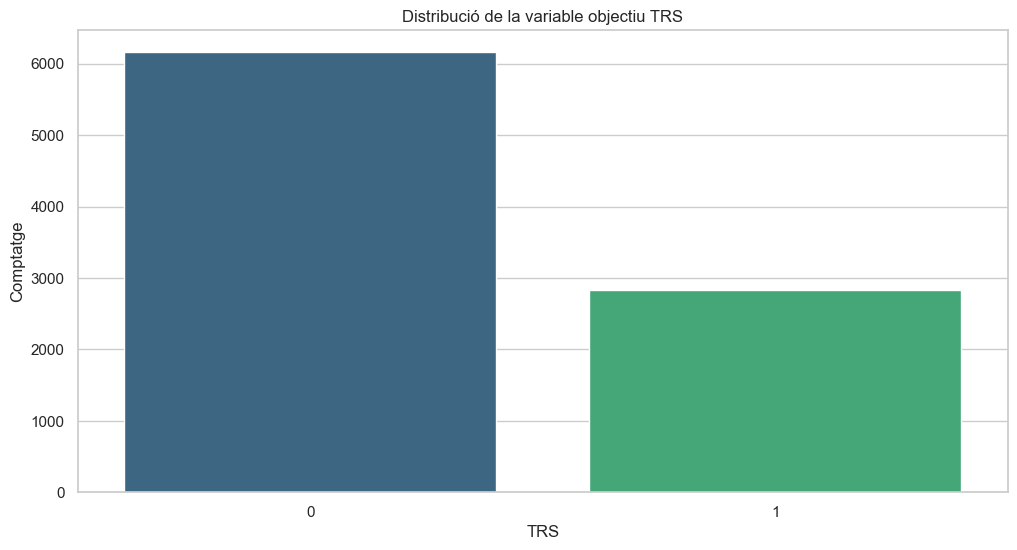

In [9]:
ratio_trs = df['TRS'].value_counts(normalize=True)
print(f"Ratio de classes:\n{ratio_trs}")
plt.figure()
sns.countplot(x='TRS', data=df, palette='viridis')
plt.title('Distribució de la variable objectiu TRS')
plt.xlabel('TRS')
plt.ylabel('Comptatge')
plt.show()

Anàlisi de les variables categòriques en funció de la classe objectiu

Variables categòriques detectades (9):
['Ethnicity', 'HLA_A_31_01', 'Family_history', 'Prior_antipsychotics', 'Del_22q11_2_status', 'CYP2D6_metabolic_phenotype', 'HLA_B_15_02', 'HLA_DRB1_04_02', 'Sex']


VARIABLE                            | P-VALUE    | SIGNIFICATIU?
----------------------------------------------------------------------
Ethnicity                           | 0.87647    | No


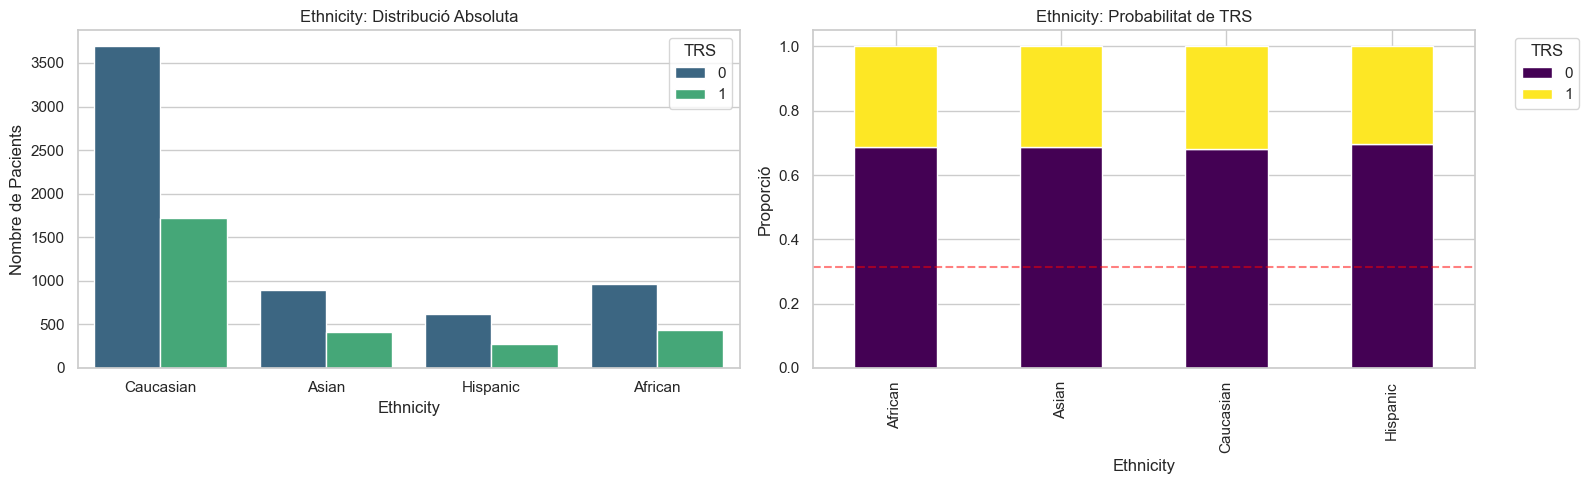

--------------------------------------------------------------------------------
HLA_A_31_01                         | 1.00000    | No


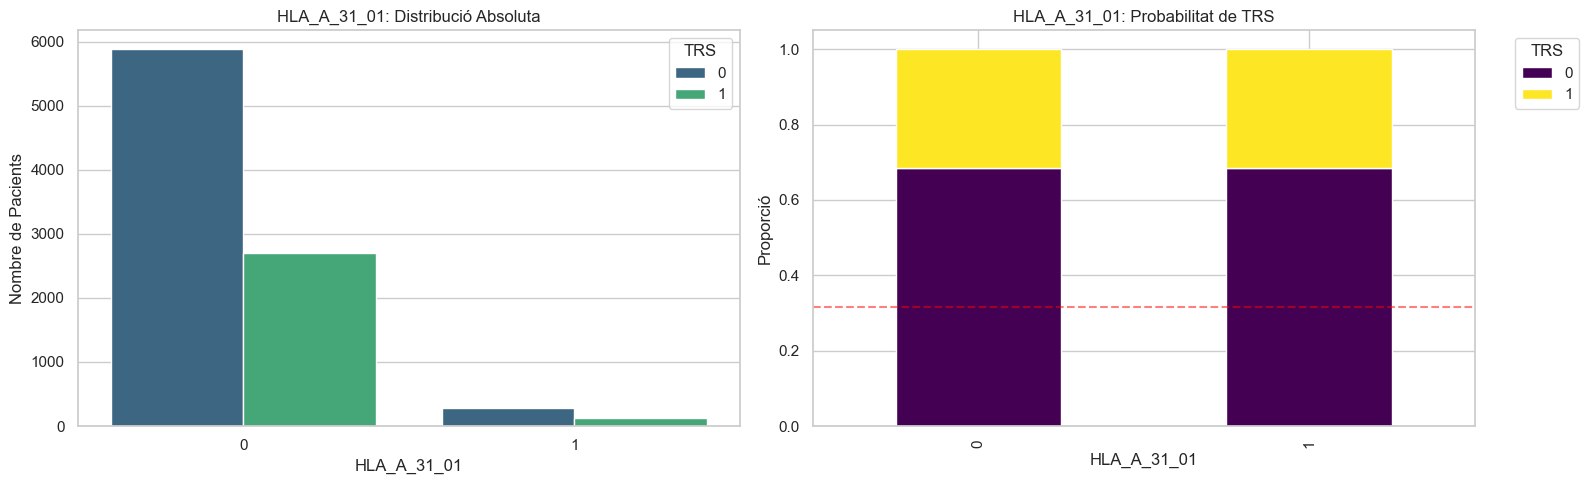

--------------------------------------------------------------------------------
Family_history                      | 0.00000    | SÍ !!!


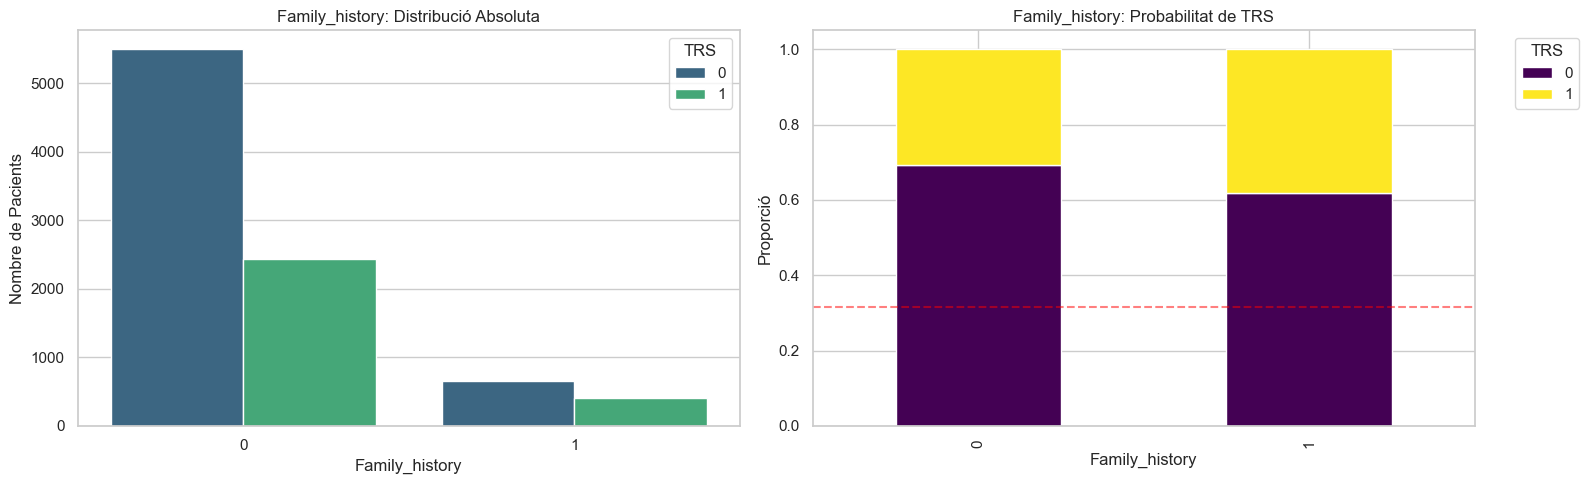

--------------------------------------------------------------------------------
Prior_antipsychotics                | 0.49976    | No


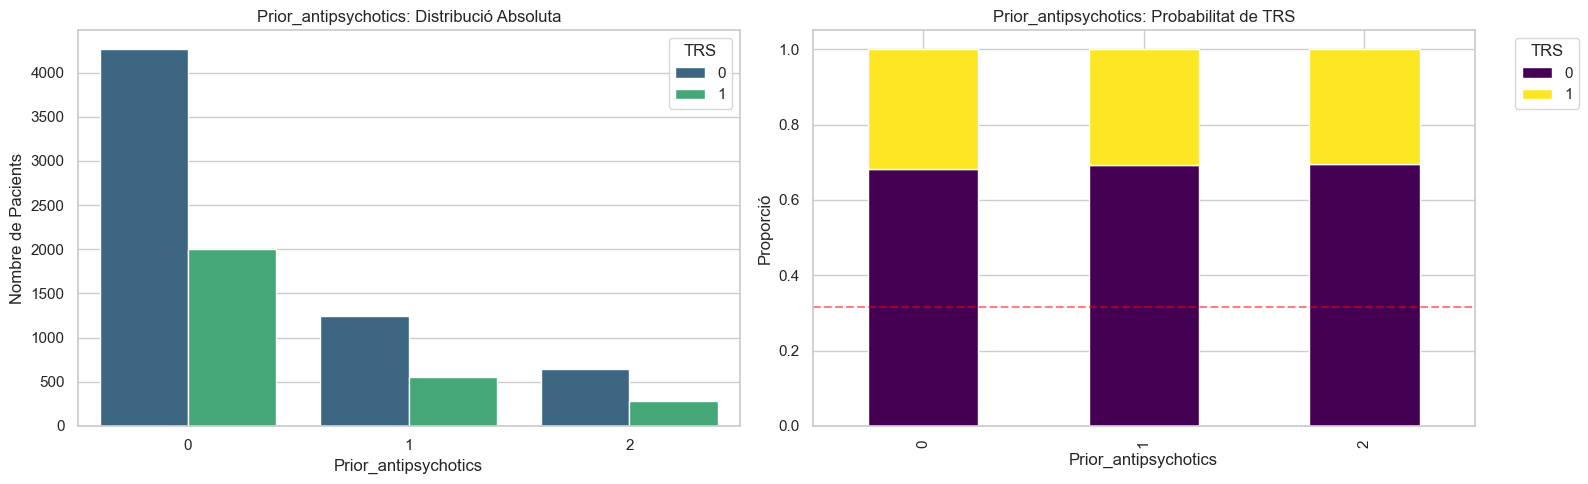

--------------------------------------------------------------------------------
Del_22q11_2_status                  | 0.28333    | No


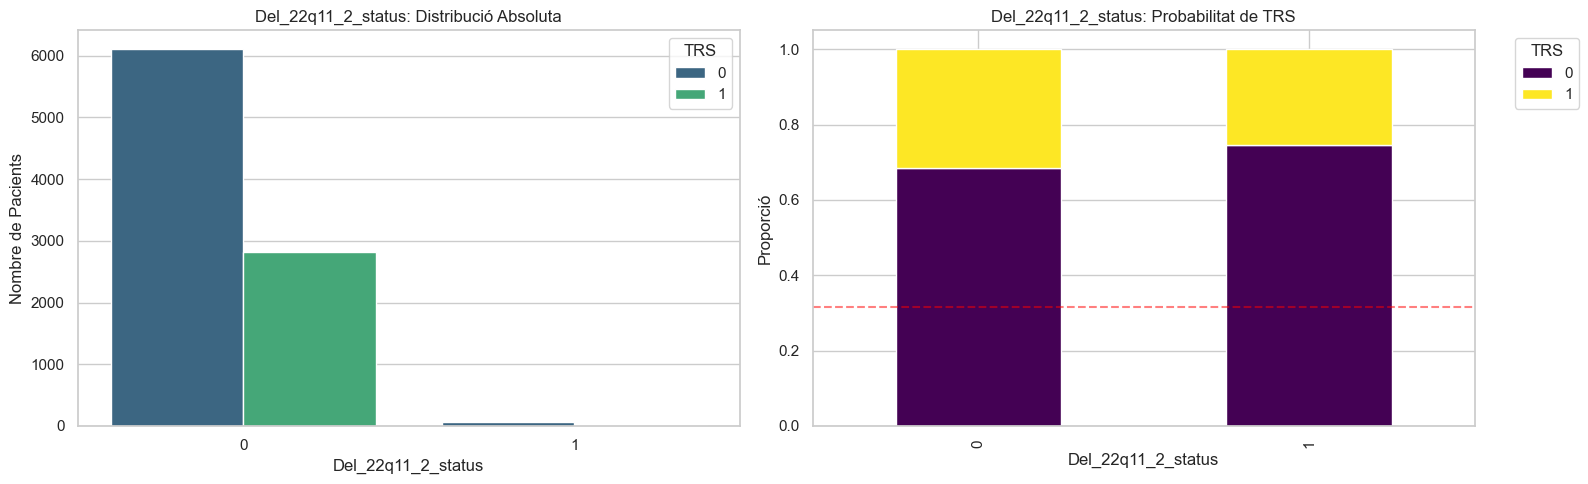

--------------------------------------------------------------------------------
CYP2D6_metabolic_phenotype          | 0.06814    | No


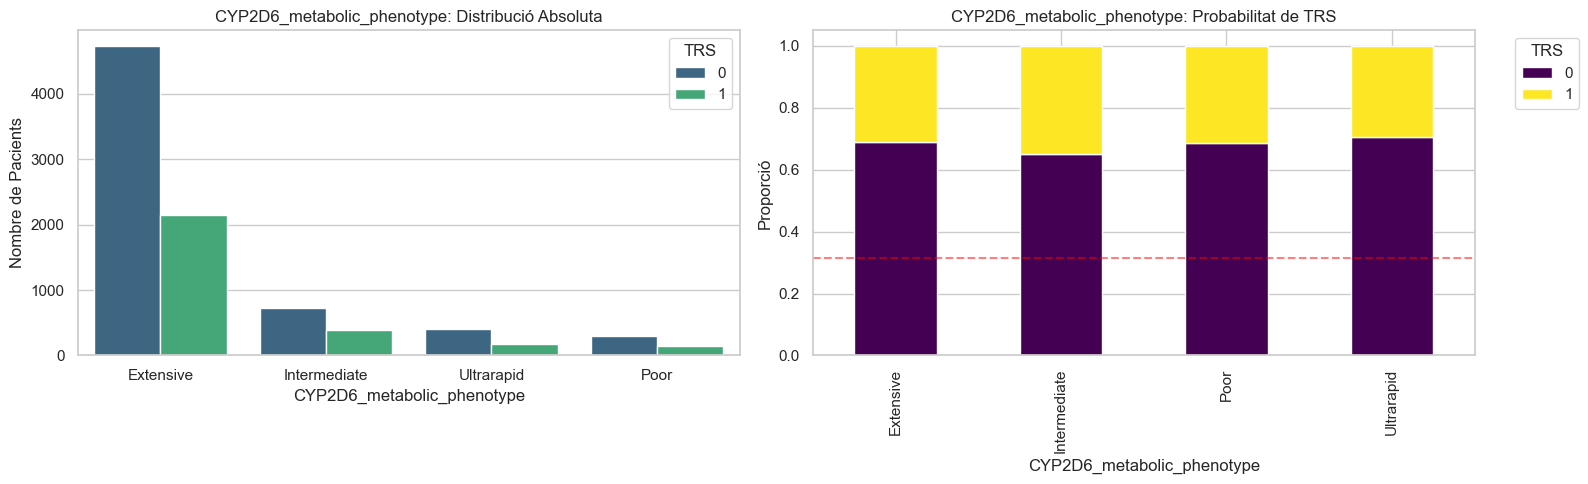

--------------------------------------------------------------------------------
HLA_B_15_02                         | 0.30161    | No


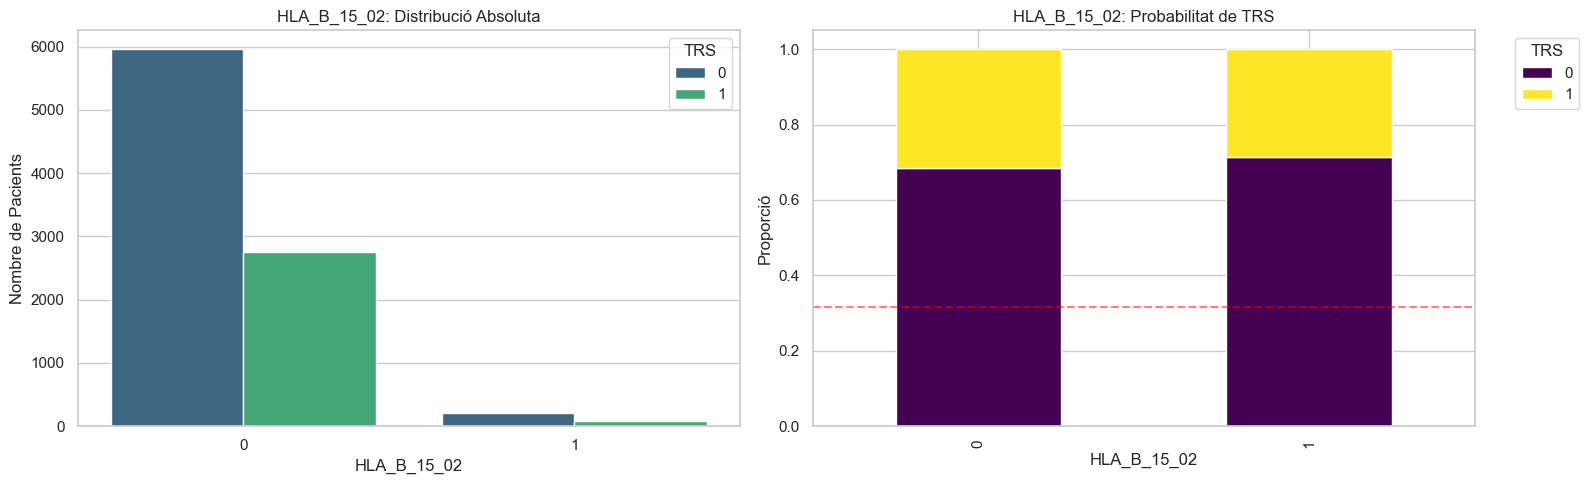

--------------------------------------------------------------------------------
HLA_DRB1_04_02                      | 0.25234    | No


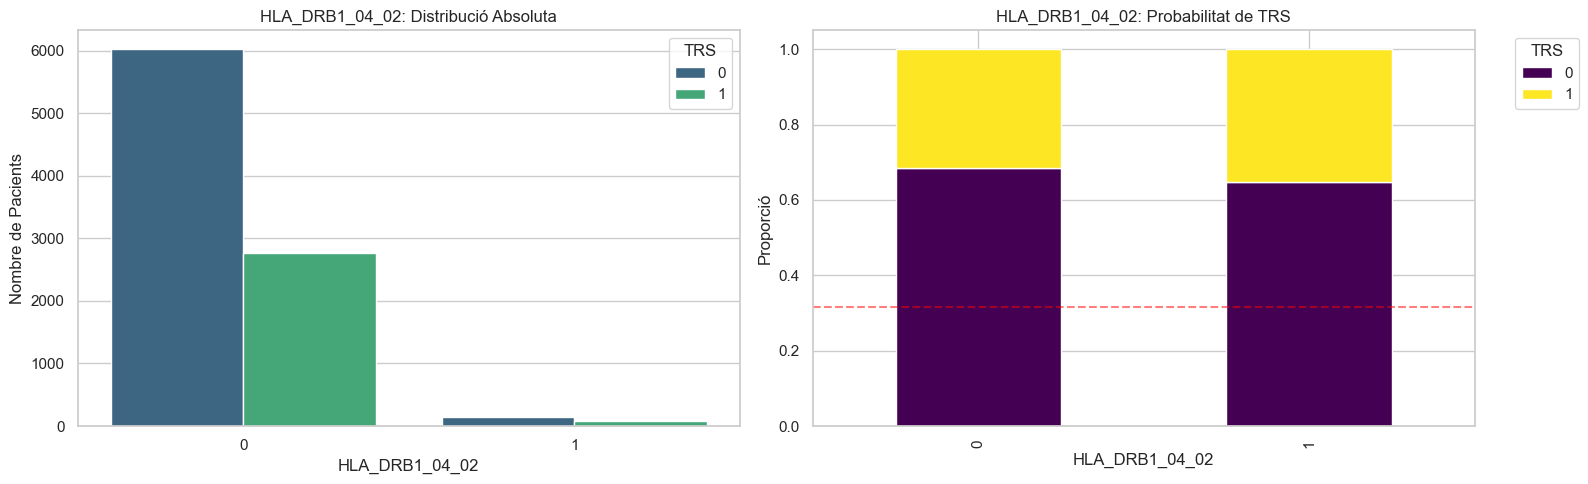

--------------------------------------------------------------------------------
Sex                                 | 0.48567    | No


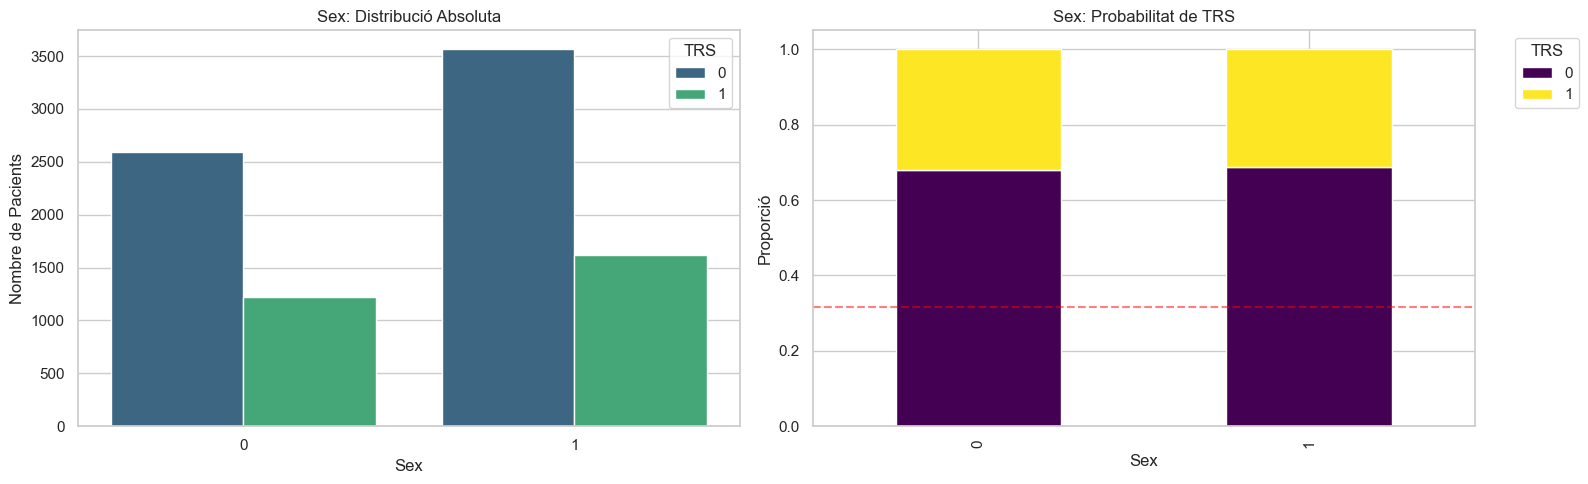

--------------------------------------------------------------------------------


In [10]:

from scipy.stats import chi2_contingency

# 1. Carregar dades
df = pd.read_csv('trs_train.csv')

# 2. DETECCIÓ AUTOMÀTICA DE VARIABLES CATEGÒRIQUES
# ------------------------------------------------
# A. Variables de tipus text (String/Object)
text_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# B. Variables numèriques amb pocs valors únics (ex: Binàries 0/1, o categories numèriques)
# Considerem "categòrica" qualsevol numèrica amb menys de 10 valors únics
num_cols = df.select_dtypes(include=['number']).columns
discrete_num_cols = [col for col in num_cols if df[col].nunique() < 10]

# C. Unim les llistes i netegem
all_categorical_cols = list(set(text_cols + discrete_num_cols))

# D. Eliminem 'TRS' (target) i 'patient_id' (identificador) si hi són
if 'TRS' in all_categorical_cols: all_categorical_cols.remove('TRS')
if 'patient_id' in all_categorical_cols: all_categorical_cols.remove('patient_id')

print(f"Variables categòriques detectades ({len(all_categorical_cols)}):")
print(all_categorical_cols)
print("\n" + "="*80 + "\n")

# 3. ANÀLISI I VISUALITZACIÓ
# -------------------------
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

# Capçalera taula resultats
print(f"{'VARIABLE':<35} | {'P-VALUE':<10} | {'SIGNIFICATIU?'}")
print("-" * 70)

for col in all_categorical_cols:
    # --- A. TEST CHI-QUADRAT ---
    contingency_table = pd.crosstab(df[col], df['TRS'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    is_significant = "SÍ !!!" if p_value < 0.05 else "No"
    print(f"{col:<35} | {p_value:.5f}    | {is_significant}")

    # --- B. GRÀFICS ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Gràfic 1: Absolut (Barres normals)
    sns.countplot(data=df, x=col, hue='TRS', ax=axes[0], palette='viridis')
    axes[0].set_title(f'{col}: Distribució Absoluta')
    axes[0].set_ylabel('Nombre de Pacients')
    
    # Gràfic 2: Relatiu (100% Stacked) - EL MÉS IMPORTANT PER VEURE EL RISC
    props = pd.crosstab(df[col], df['TRS'], normalize='index')
    props.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
    
    axes[1].set_title(f'{col}: Probabilitat de TRS')
    axes[1].set_ylabel('Proporció')
    axes[1].legend(title='TRS', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Línia de la mitjana global
    global_mean = df['TRS'].mean()
    axes[1].axhline(y=global_mean, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    print("-" * 80)


Anàlisi de la distribució de les variables numèriques.
Els models són sensibles a distribucions no normals, per tant, volem una mesura de Skewness també.

Variables contínues detectades (17):
['Age', 'Duration_untreated_psychosis', 'Initial_response', 'Lymphocyte_count', 'Neutrophil_count', 'BMI', 'Triglycerides', 'Glucose', 'Alkaline_phosphatase', 'Polygenic_risk_score', 'IL_17A', 'CCL23', 'TWEAK', 'Ki_whole_striatum', 'Ki_associative_striatum', 'SUVRc_whole_striatum', 'SUVRc_associative_striatum']


ANÀLISI D'ASIMETRIA (SKEWNESS):
--------------------------------------------------------------------------------
                    Variable  Skewness  Kurtosis                                    Estat
Duration_untreated_psychosis  2.150479  5.323006 🔴 MOLT ASIMÈTRICA (Requereix Log/BoxCox)
                         Age  1.258793  2.065980 🔴 MOLT ASIMÈTRICA (Requereix Log/BoxCox)
  SUVRc_associative_striatum  0.457536 -0.422680                     🟢 NORMAL (Simètrica)
        SUVRc_whole_striatum  0.434121 -0.408815                     🟢 NORMAL (Simètrica)
        Polygenic_risk_score  0.405186  0.323084                     🟢 NORMAL (Simètr

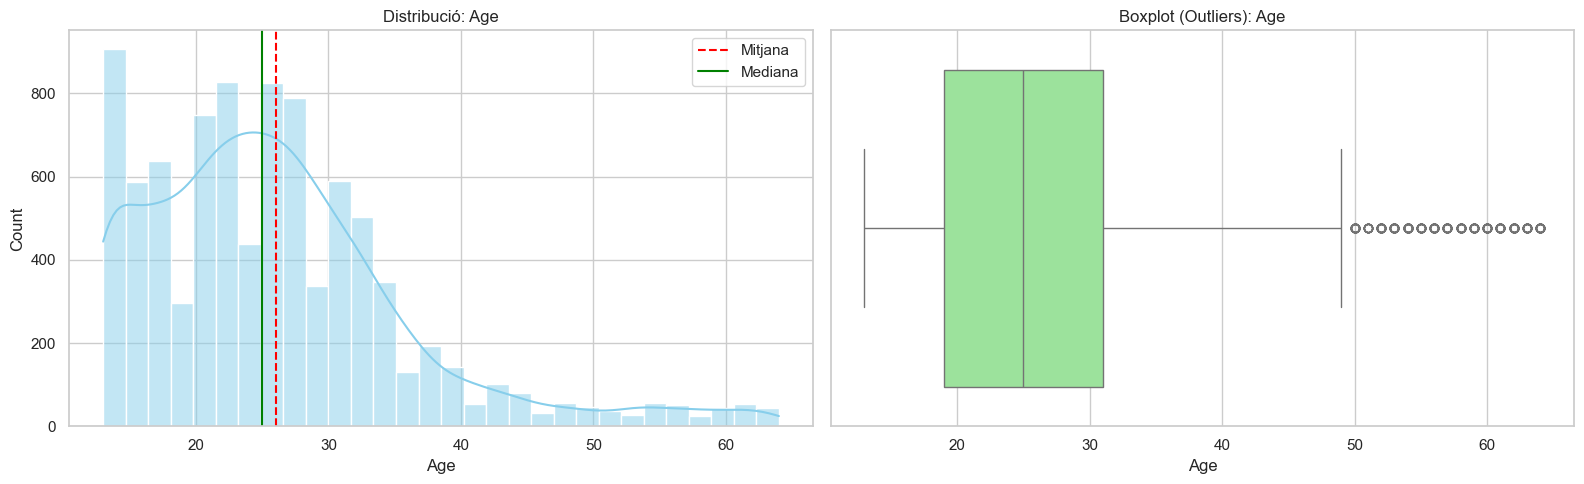

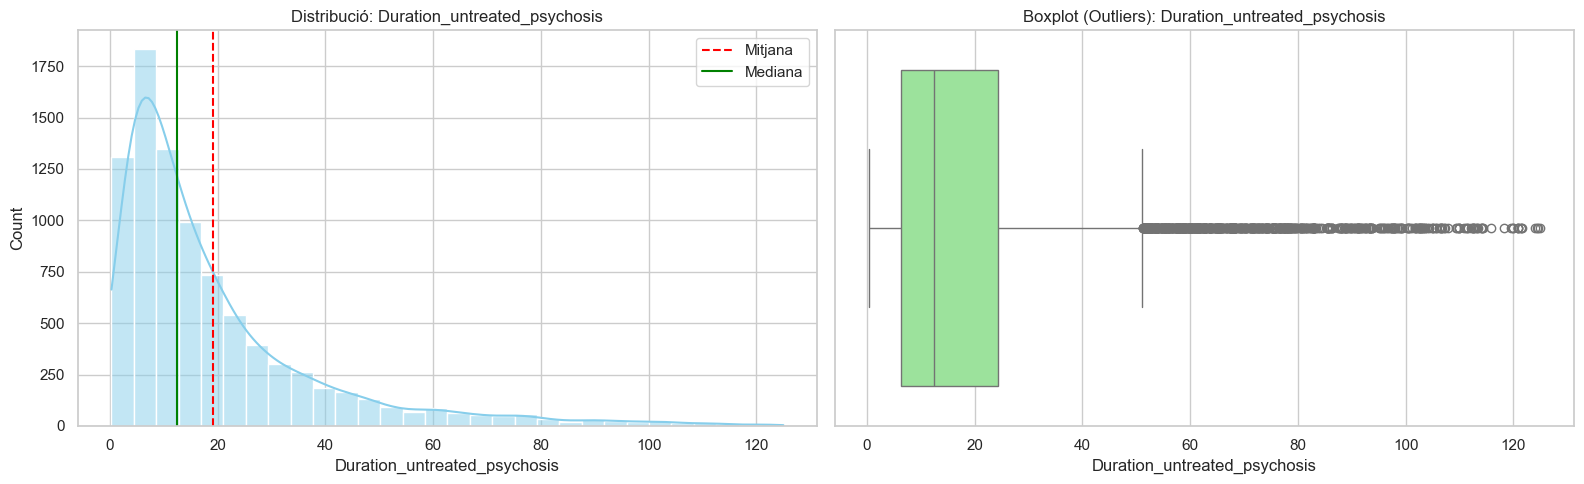

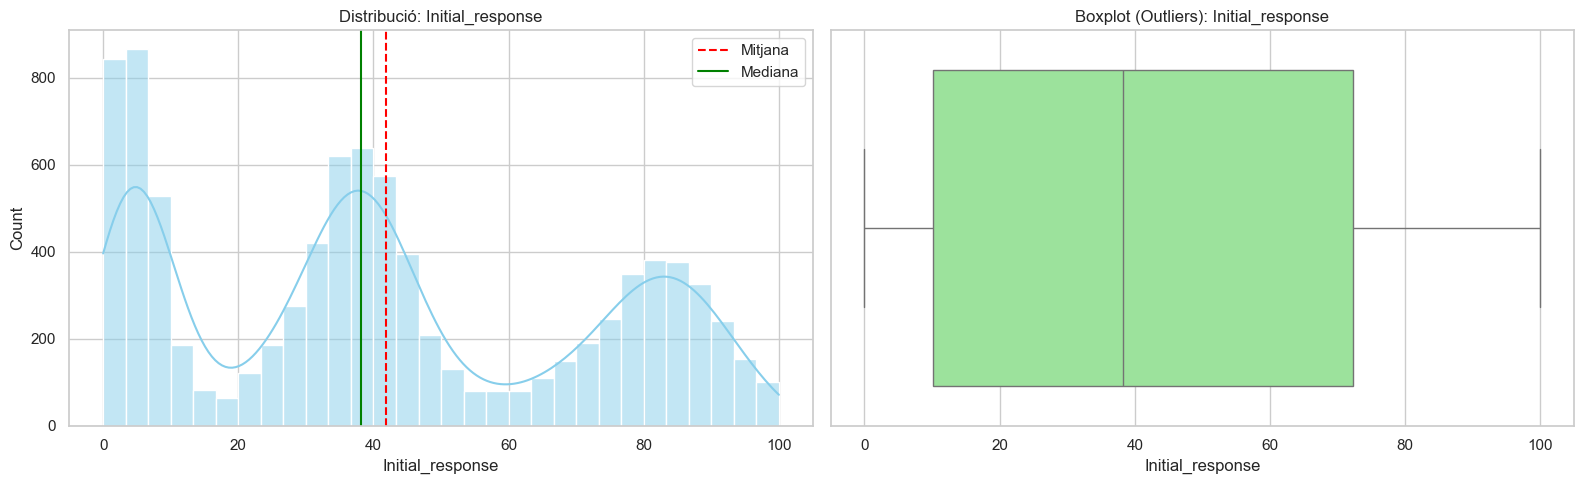

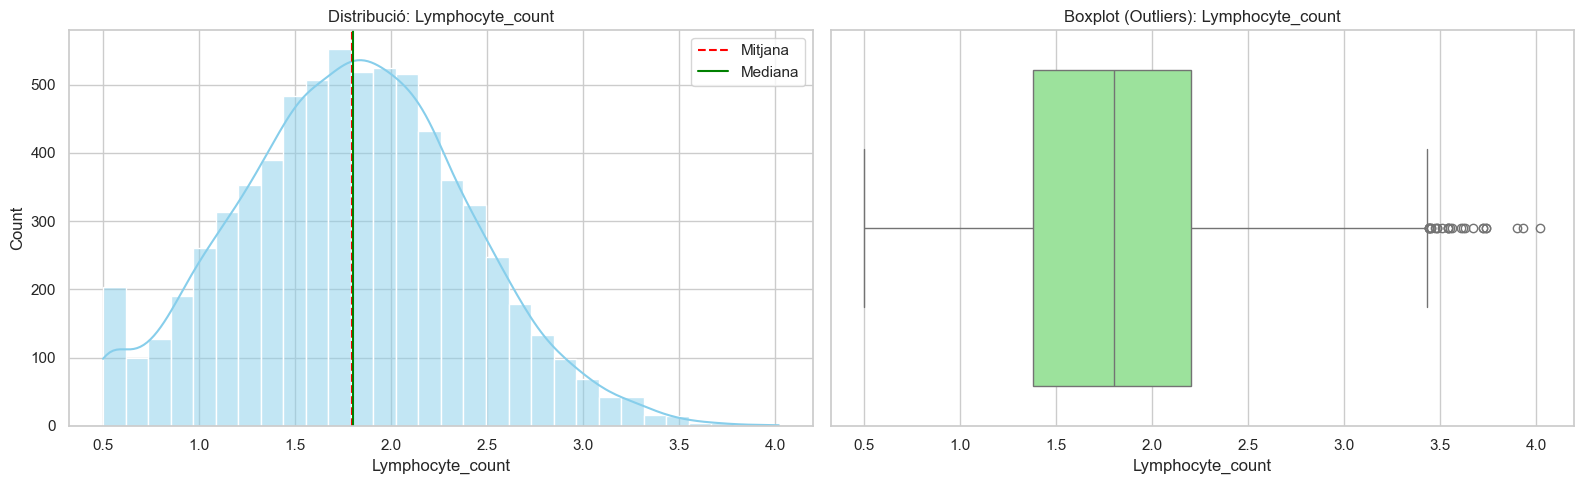

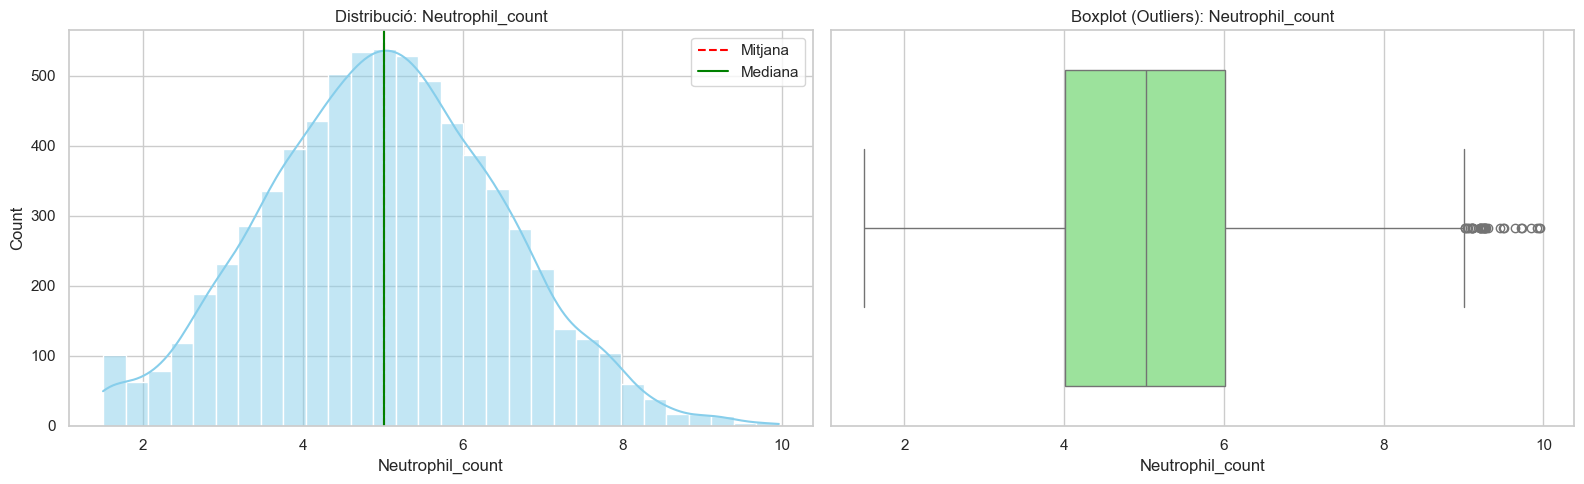

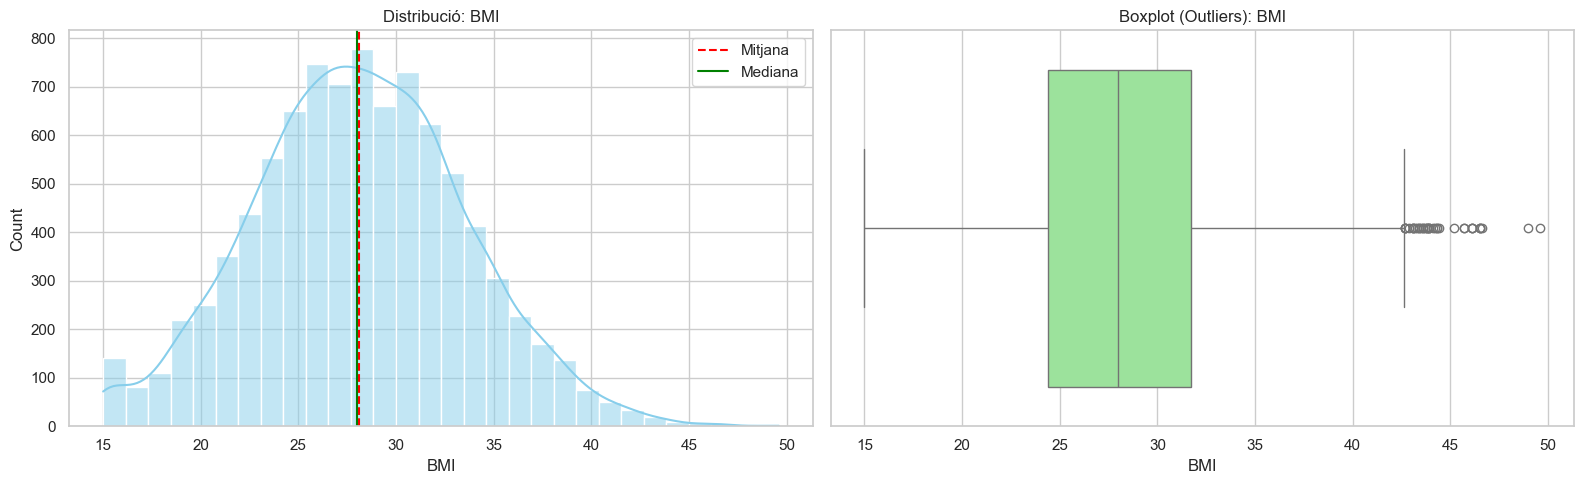

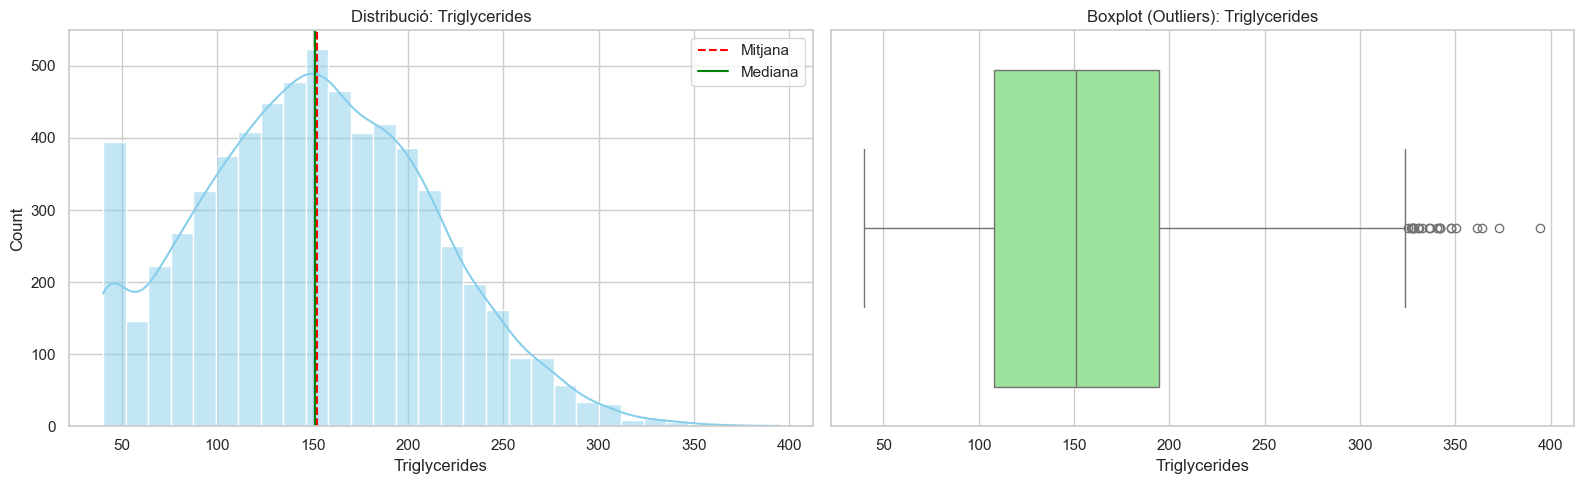

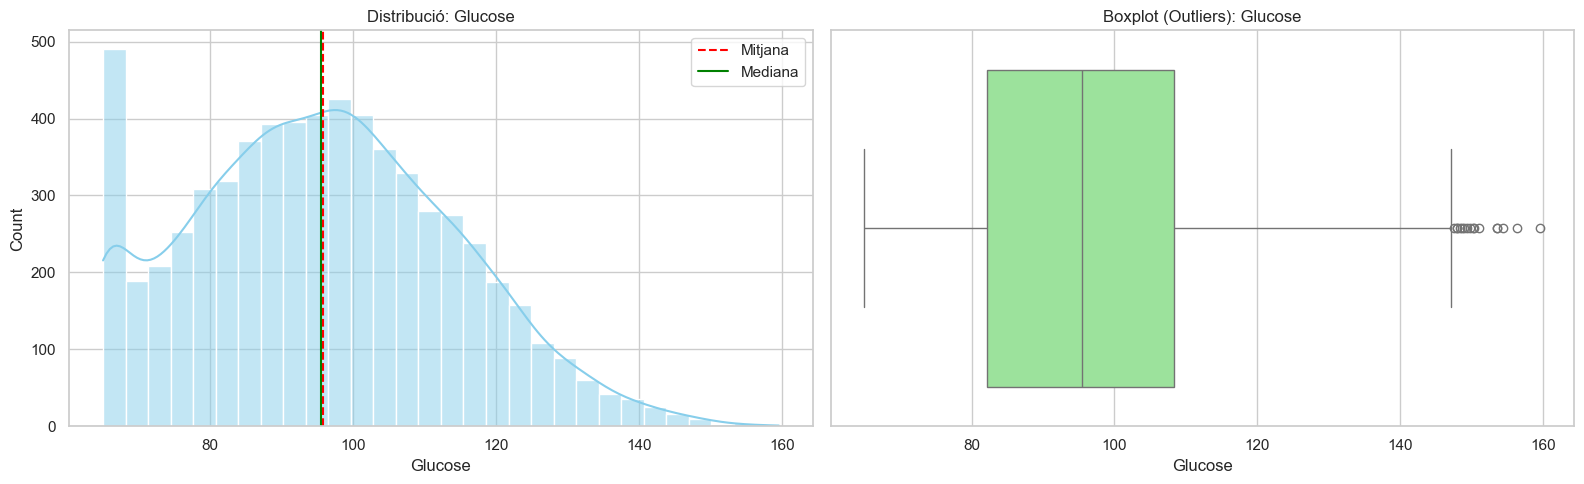

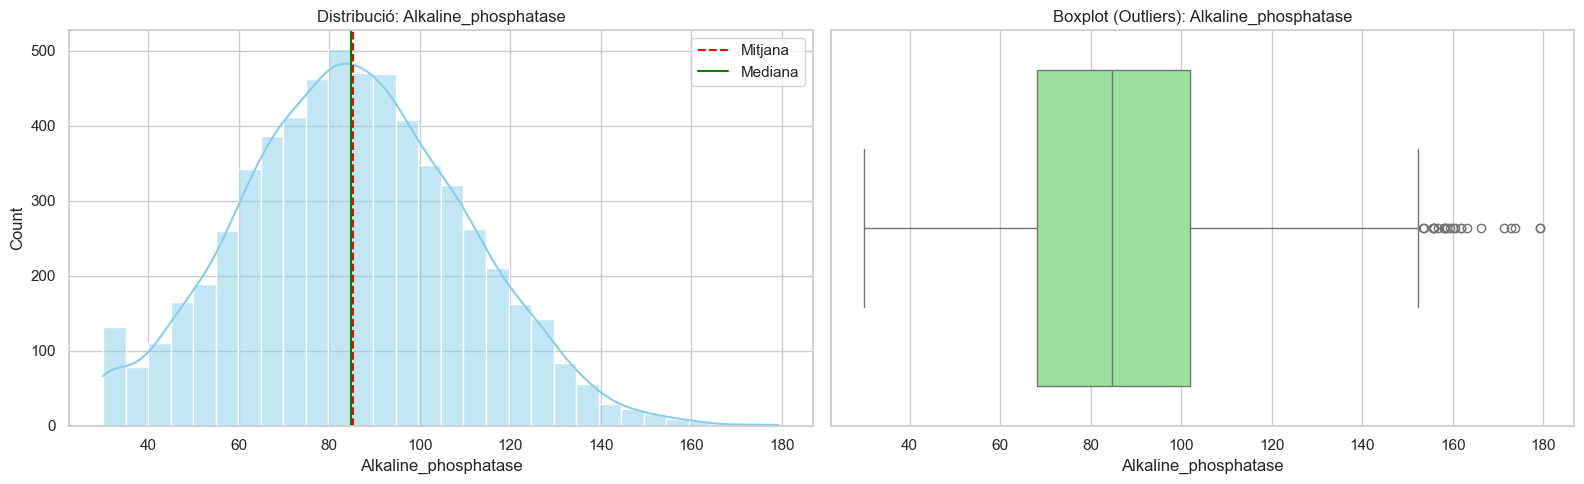

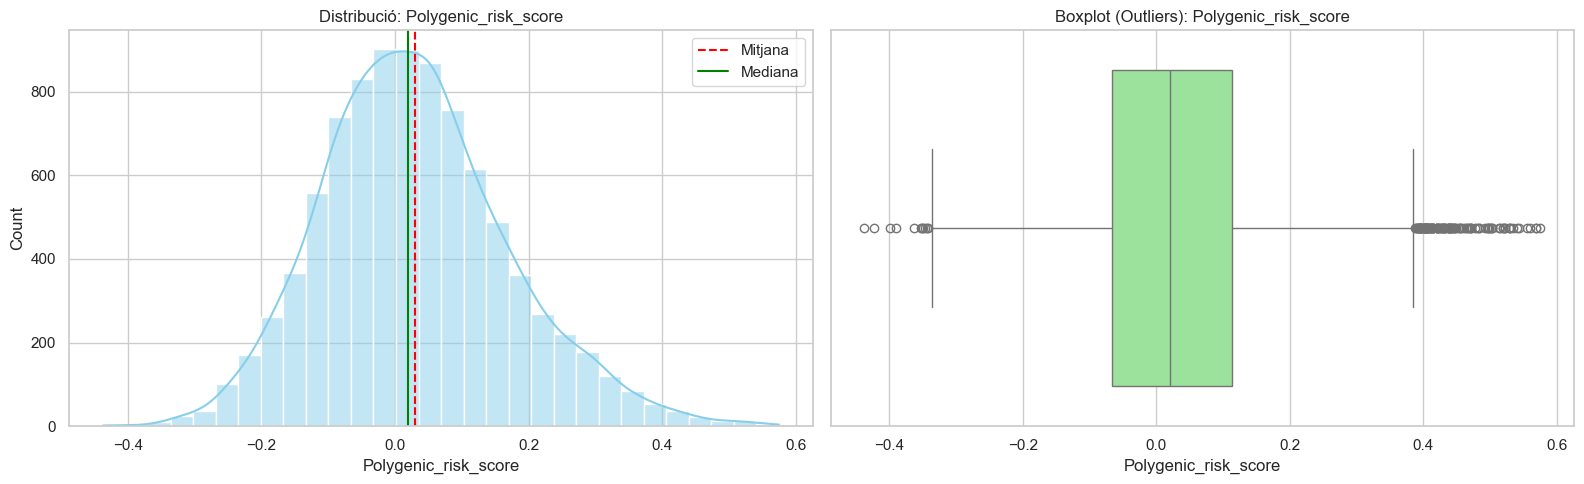

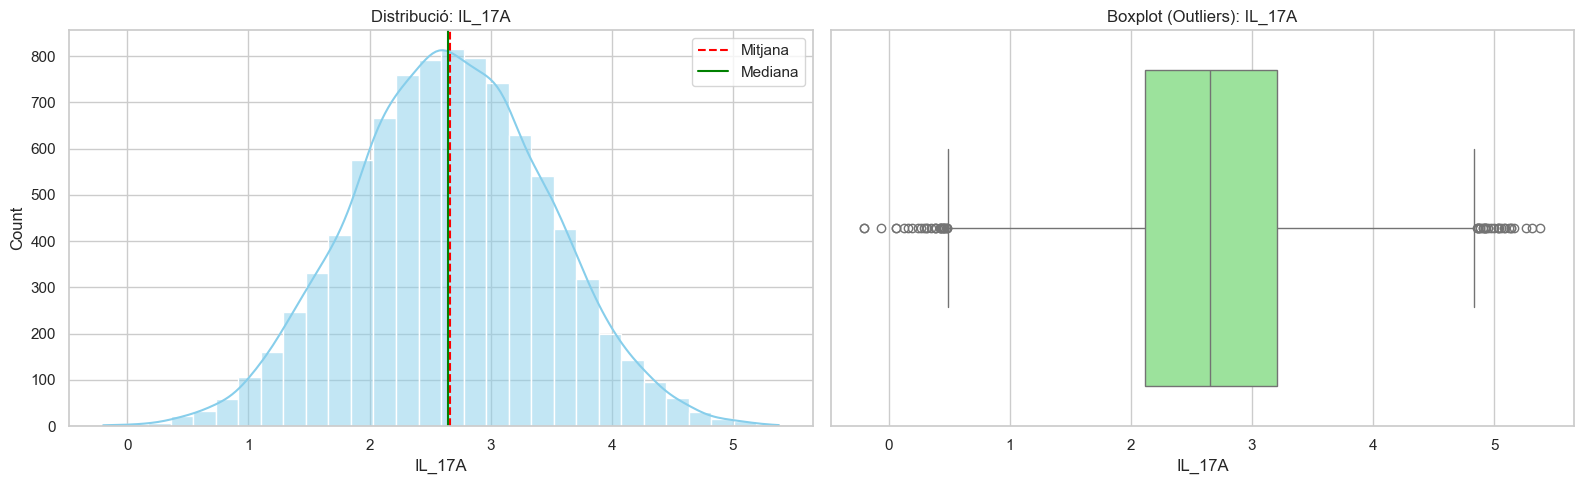

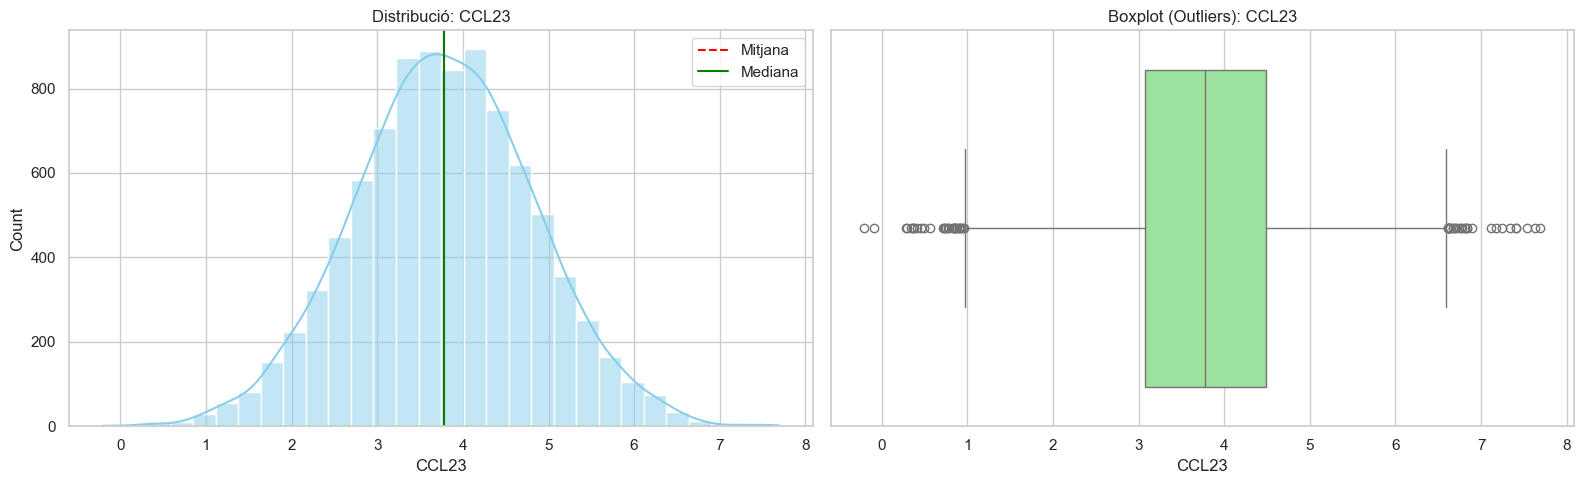

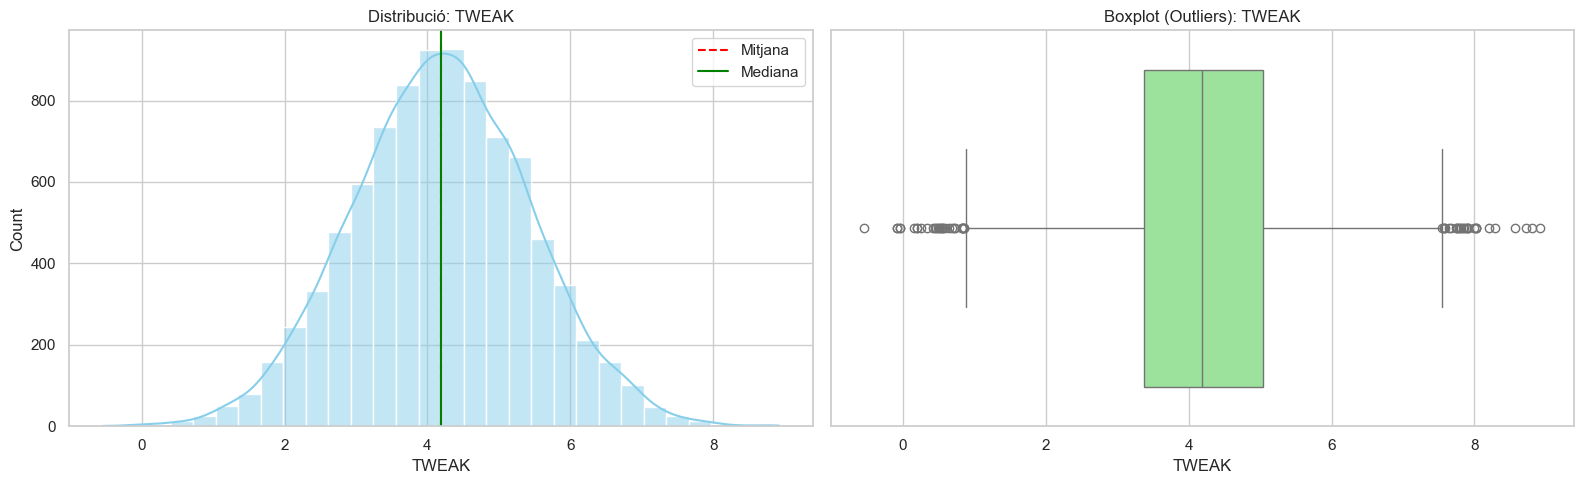

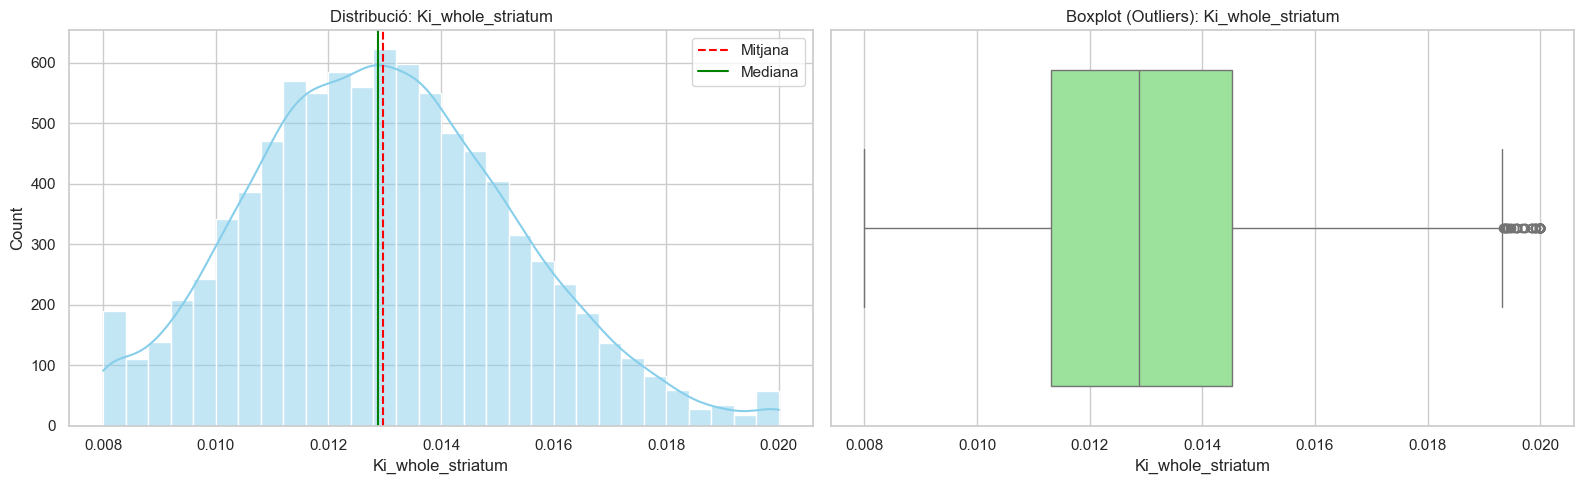

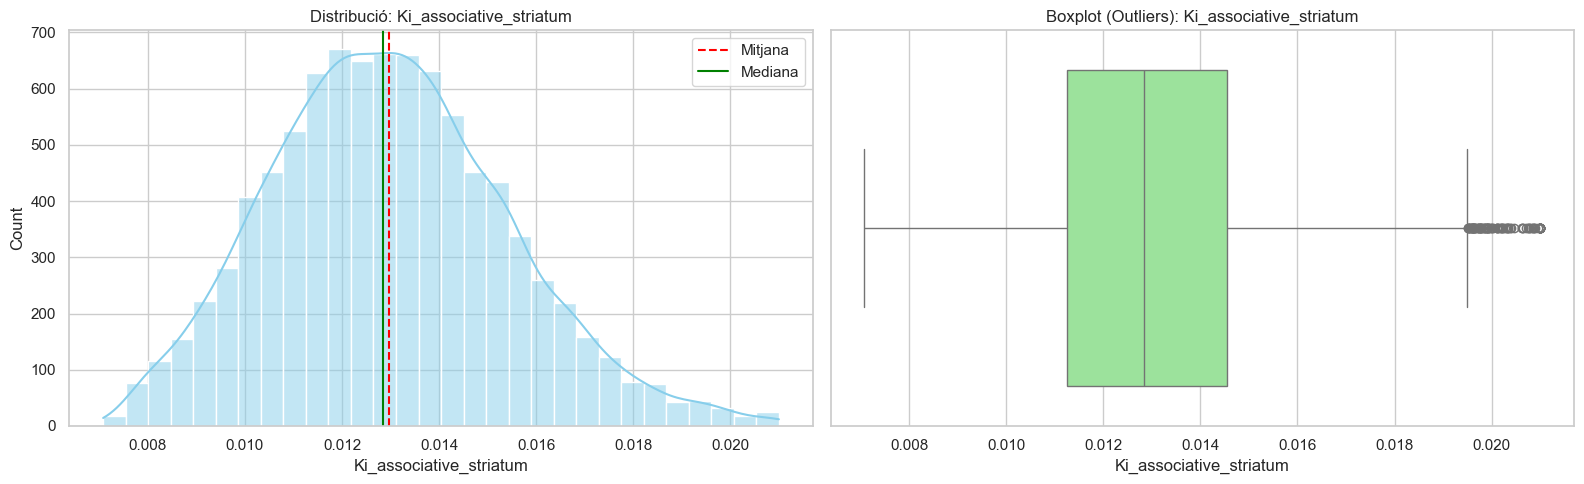

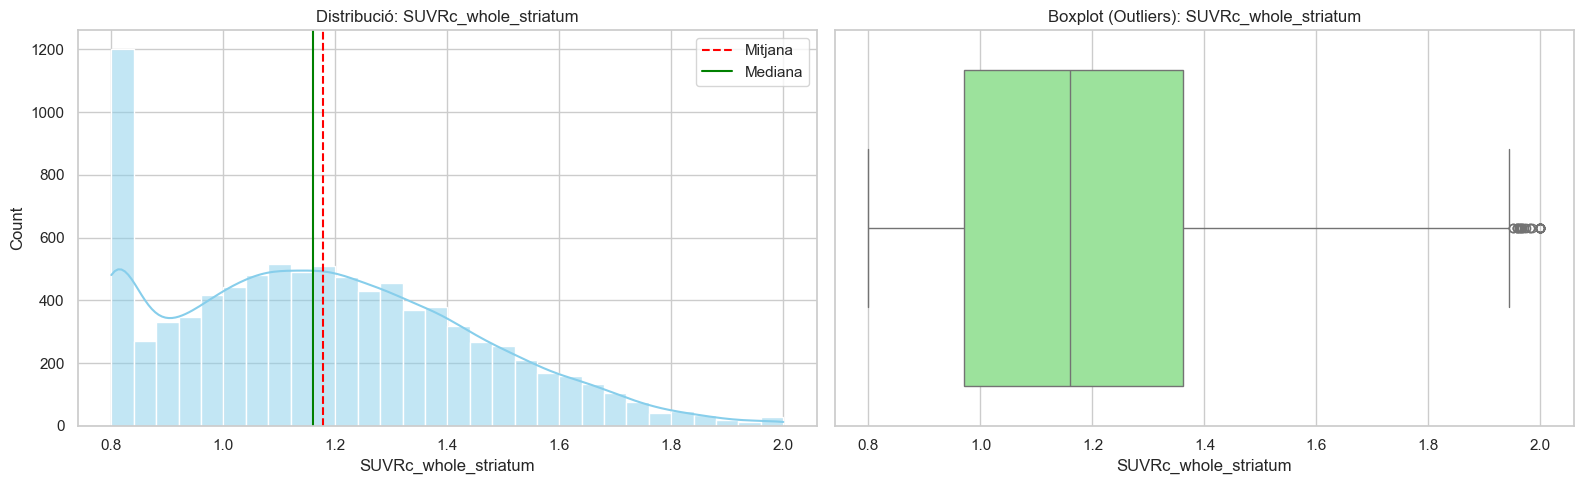

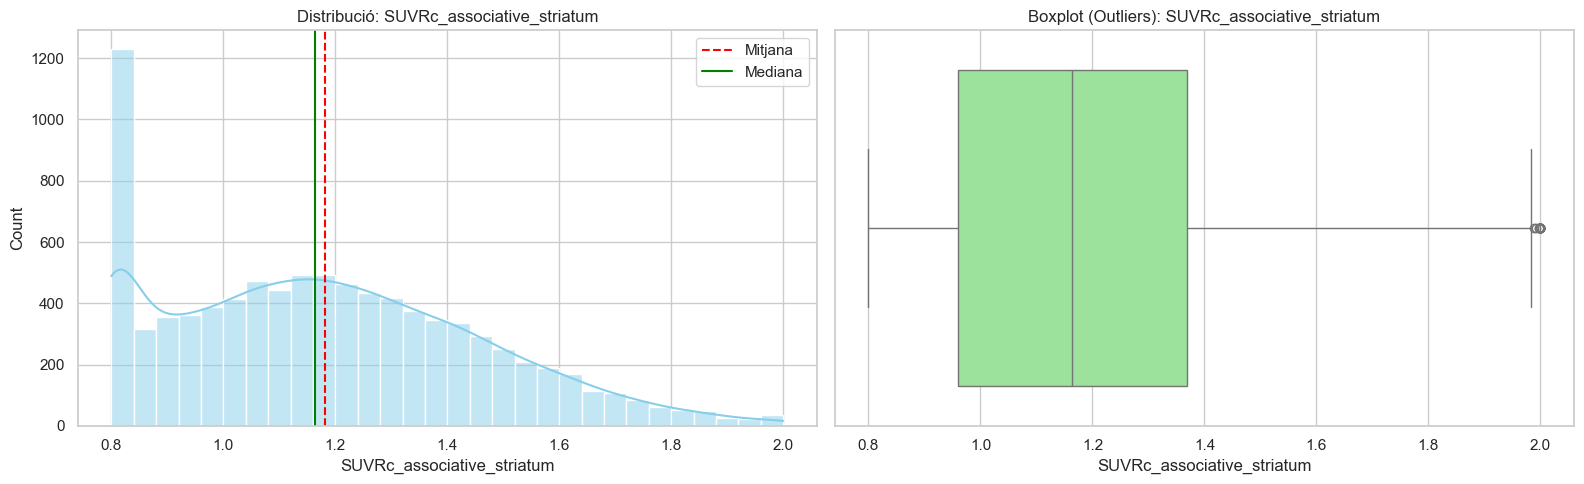

In [11]:
from scipy.stats import skew, kurtosis


num_cols = df.select_dtypes(include=['number']).columns
continuous_cols = [col for col in num_cols if df[col].nunique() > 10 and col != 'patient_id']

print(f"Variables contínues detectades ({len(continuous_cols)}):")
print(continuous_cols)
print("\n" + "="*80 + "\n")

# 3. TAULA RESUM DE SKEWNESS I KURTOSIS
skew_data = []
for col in continuous_cols:
    # Eliminem NaNs per al càlcul estadístic
    clean_series = df[col].dropna()
    col_skew = skew(clean_series)
    col_kurt = kurtosis(clean_series)
    
    # Classifiquem la gravetat de l'asimetria
    if abs(col_skew) > 1:
        status = "🔴 MOLT ASIMÈTRICA (Requereix Log/BoxCox)"
    elif abs(col_skew) > 0.5:
        status = "🟠 MODERADA"
    else:
        status = "🟢 NORMAL (Simètrica)"
        
    skew_data.append({
        'Variable': col,
        'Skewness': col_skew,
        'Kurtosis': col_kurt,
        'Estat': status
    })

skew_df = pd.DataFrame(skew_data).sort_values('Skewness', key=abs, ascending=False)

print("ANÀLISI D'ASIMETRIA (SKEWNESS):")
print("-" * 80)
# Mostrem la taula amb format bonic
print(skew_df.to_string(index=False))
print("-" * 80)
print("Nota: Skewness > 0 significa cua a la dreta. Skewness < 0 significa cua a l'esquerra.")
print("\n" + "="*80 + "\n")

# 4. VISUALITZACIÓ GRÀFICA
sns.set_style("whitegrid")

for col in continuous_cols:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # GRÀFIC 1: Histograma + Densitat (KDE)
    sns.histplot(data=df, x=col, kde=True, ax=axes[0], color='skyblue', bins=30)
    axes[0].set_title(f'Distribució: {col}')
    
    # Afegim línies per Mitjana i Mediana
    axes[0].axvline(df[col].mean(), color='red', linestyle='--', label='Mitjana')
    axes[0].axvline(df[col].median(), color='green', linestyle='-', label='Mediana')
    axes[0].legend()

    # GRÀFIC 2: Boxplot (Per veure Outliers)
    sns.boxplot(x=df[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot (Outliers): {col}')
    
    plt.tight_layout()
    plt.show()


Anàlisi de les correlacions de les variables numèriques per observar linearitat o colinearitat


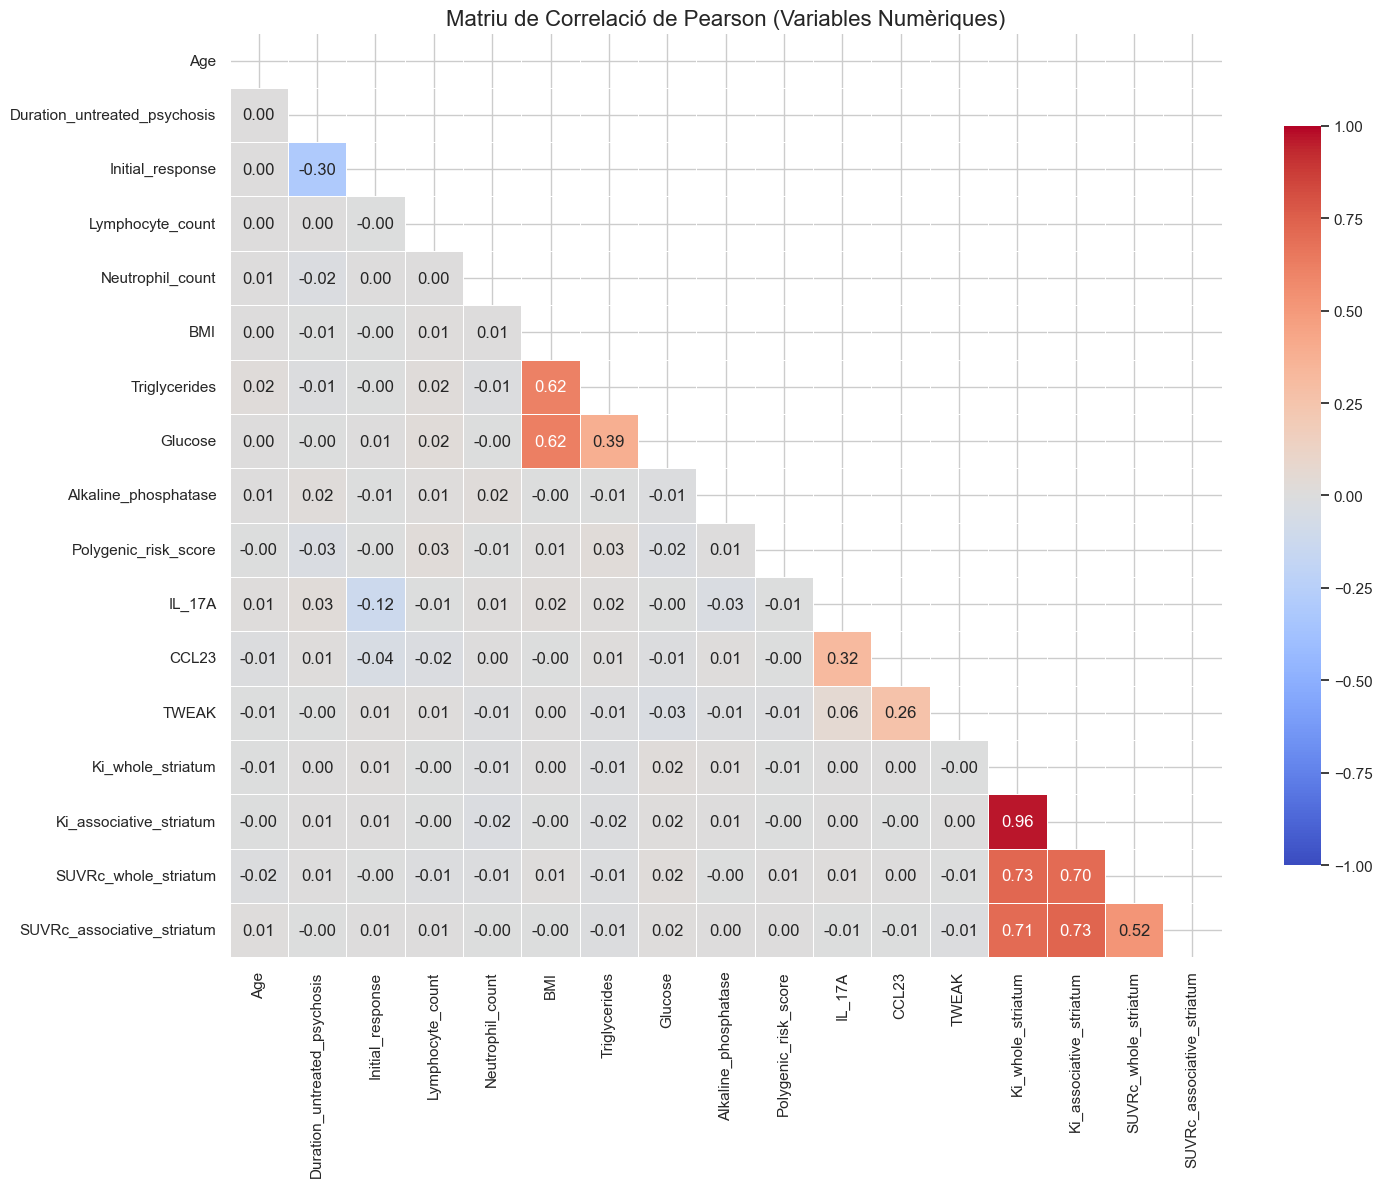


ALERTA DE MULTICOLINEALITAT (Coeficient > 0.7):
------------------------------------------------------------
Ki_associative_striatum        <--> Ki_whole_striatum              : 0.9644
SUVRc_whole_striatum           <--> Ki_whole_striatum              : 0.7265
SUVRc_whole_striatum           <--> Ki_associative_striatum        : 0.7043
SUVRc_associative_striatum     <--> Ki_whole_striatum              : 0.7055
SUVRc_associative_striatum     <--> Ki_associative_striatum        : 0.7336


In [12]:

numerical_cols = df.select_dtypes(include=['number']).columns
# treiem les variables binàries i categòriques codificades numèricament
numerical_cols = [col for col in numerical_cols if df[col].nunique() > 10]
cols_to_analyze = [col for col in numerical_cols if col not in ['patient_id', 'TRS']]

# 3. CALCULAR CORRELACIÓ (Pearson)
corr_matrix = df[cols_to_analyze].corr()

# 4. VISUALITZACIÓ (HEATMAP)
plt.figure(figsize=(16, 12))

# Màscara per amagar la meitat superior (és redundant)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Dibuixar el heatmap
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,              # Mostrar números
            fmt=".2f",               # 2 decimals
            cmap='coolwarm',         # Blau-Vermell (Vermell = alta correlació positiva)
            vmax=1, vmin=-1,         # Escala de -1 a 1
            center=0,
            linewidths=.5,
            cbar_kws={"shrink": .8})

plt.title('Matriu de Correlació de Pearson (Variables Numèriques)', fontsize=16)
plt.show()

# 5. LLISTA DE PARELLS AMB ALTA COLINEALITAT (> 0.7 o < -0.7)
print("\nALERTA DE MULTICOLINEALITAT (Coeficient > 0.7):")
print("-" * 60)

# Recorrem la matriu per trobar valors alts
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            var1 = corr_matrix.columns[i]
            var2 = corr_matrix.columns[j]
            coef = corr_matrix.iloc[i, j]
            print(f"{var1:<30} <--> {var2:<30} : {coef:.4f}")
            high_corr_pairs.append((var1, var2, coef))

if not high_corr_pairs:
    print("No s'han detectat problemes greus de multicolinealitat.")


Anàlisi de les components principals. Fem una imputació perquè PCA no tolera NaNs.

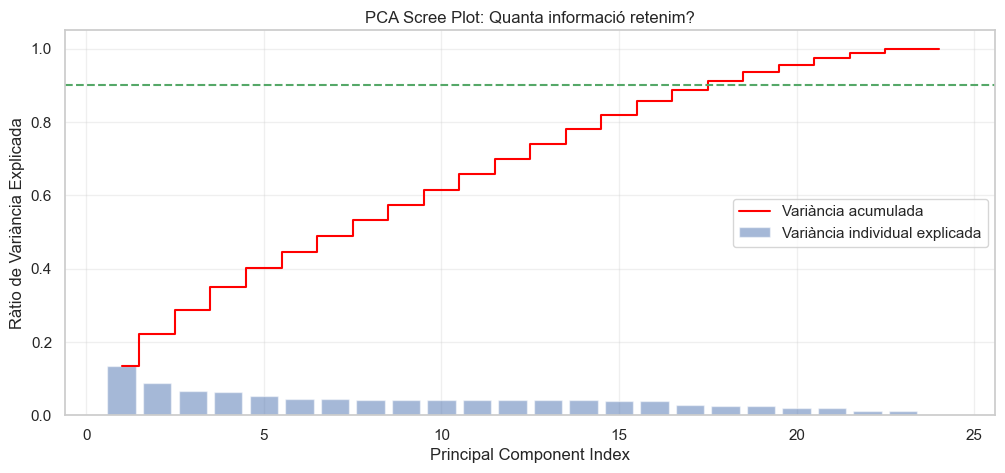

Necessites 20 components per explicar el 95% de la variància.
------------------------------------------------------------

TOP VARIABLES PER AL PRIMER COMPONENT (PC1):
Ki_associative_striatum       0.537087
Ki_whole_striatum             0.536197
SUVRc_associative_striatum    0.460752
SUVRc_whole_striatum          0.459025
Prior_antipsychotics          0.018739
Name: PC1, dtype: float64

TOP VARIABLES PER AL SEGON COMPONENT (PC2):
BMI                   0.623440
Glucose               0.552895
Triglycerides         0.550283
Del_22q11_2_status    0.026757
HLA_B_15_02           0.022315
Name: PC2, dtype: float64


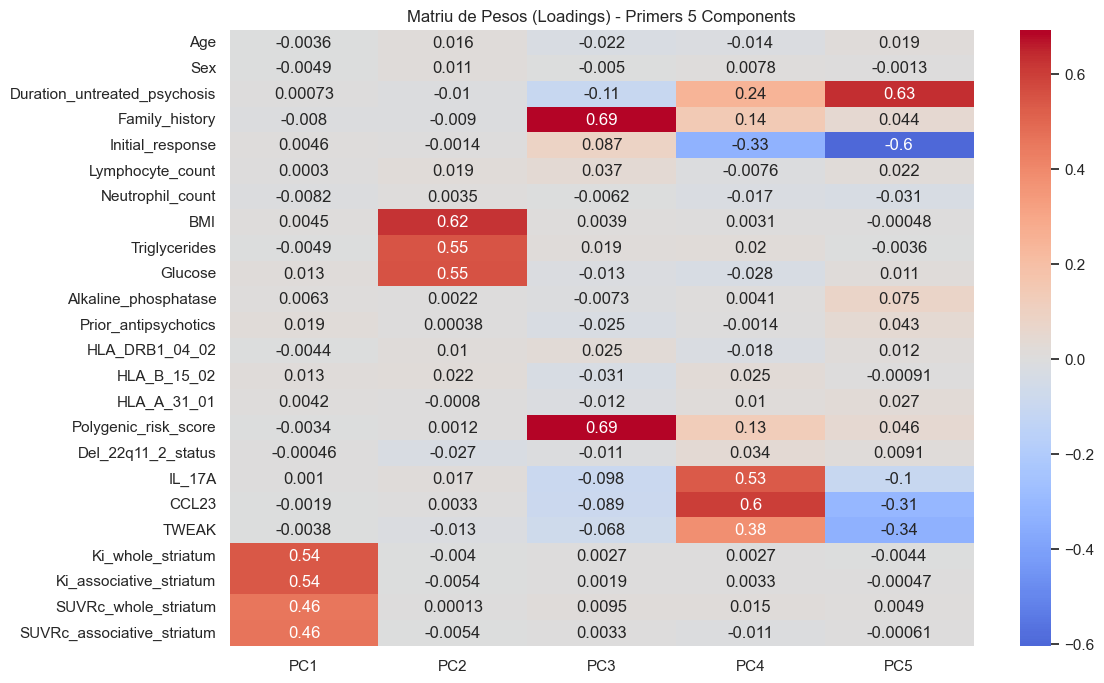

In [14]:

features = df.select_dtypes(include=['number']).columns.tolist()
if 'patient_id' in features: features.remove('patient_id')
if 'TRS' in features: features.remove('TRS')

X = df[features]


imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)

# IMPORTANT: PCA requereix dades escalades (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 2. APLICAR PCA
# --------------
# Calculem tots els components possibles per veure la variància explicada
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 3. VISUALITZACIÓ (SCREE PLOT)
# -----------------------------
# Variància explicada per cada component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(12, 5))

# Gràfic de barres (Variància individual)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Variància individual explicada')

# Gràfic de línia (Variància acumulada)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
         label='Variància acumulada', color='red')

plt.ylabel('Ràtio de Variància Explicada')
plt.xlabel('Principal Component Index')
plt.title('PCA Scree Plot: Quanta informació retenim?')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Línia de tall al 90% o 95%
plt.axhline(y=0.90, color='g', linestyle='--', label='90% threshold')
plt.show()

# Imprimir quants components calen per arribar al 95%
n_components90 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Necessites {n_components90} components per explicar el 95% de la variància.")
print("-" * 60)

# 4. INTERPRETACIÓ (LOADINGS)
# ---------------------------
# Quines variables originals pesen més en els primers components?
# Mostrem els 3 primers components (PC1, PC2, PC3)

loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(len(features))], 
    index=features
)

print("\nTOP VARIABLES PER AL PRIMER COMPONENT (PC1):")
print(loadings['PC1'].abs().sort_values(ascending=False).head(5))

print("\nTOP VARIABLES PER AL SEGON COMPONENT (PC2):")
print(loadings['PC2'].abs().sort_values(ascending=False).head(5))

# Heatmap dels loadings (per veure patrons visuals)
plt.figure(figsize=(12, 8))
sns.heatmap(loadings.iloc[:, :5], cmap='coolwarm', center=0, annot=True)
plt.title('Matriu de Pesos (Loadings) - Primers 5 Components')
plt.show()


Després d'aquest anàlisi, decidim:

- Per a SVM i Reg. Logística: No eliminem variables, sinó que entrenem amb PCA. També transformatem les variables numèriques per reduir skewness (Box-Cox o Yeo-Johnson segons correspongui).
- Per a XGBoost: No fem PCA, però eliminem variables molt correlacionades (correlació > 0.9) i variables amb skewness > 3 o < -3.


## 2. Preprocessament de dades per model

### 2.1 Per a SVM

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Carregar dades
df = pd.read_csv('trs_train.csv')

# Separar X i y
if 'TRS' in df.columns:
    X = df.drop('TRS', axis=1)
    y = df['TRS']
else:
    raise ValueError("No s'ha trobat la columna objectiu 'TRS'")

# Eliminar ID si existeix
if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)

print(f"Dimensions inicials: {X.shape}")


Dimensions inicials: (9000, 26)


1. Particionar

In [4]:
# Dividim 80% Train, 20% Test
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train SVM shape: {X_train_svm.shape}")
print(f"Test SVM shape:  {X_test_svm.shape}")


Train SVM shape: (7200, 26)
Test SVM shape:  (1800, 26)


2. Codificació de variables categòriques amb One-Hot Encoding

In [5]:
# Identifiquem columnes
cat_cols = X_train_svm.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_svm.select_dtypes(exclude=['object']).columns.tolist()

print(f"Variables categòriques: {cat_cols}")

# Inicialitzem l'encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# Fit només en train
ohe.fit(X_train_svm[cat_cols])

# Transformem
X_train_cat_encoded = ohe.transform(X_train_svm[cat_cols])
X_test_cat_encoded = ohe.transform(X_test_svm[cat_cols])

# Convertim a DataFrame
new_cat_names = ohe.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat_encoded, columns=new_cat_names, index=X_train_svm.index)
X_test_cat_df = pd.DataFrame(X_test_cat_encoded, columns=new_cat_names, index=X_test_svm.index)

# Reconstruïm els DataFrames (Numèriques + Categòriques codificades)
X_train_svm = pd.concat([X_train_svm[num_cols], X_train_cat_df], axis=1)
X_test_svm = pd.concat([X_test_svm[num_cols], X_test_cat_df], axis=1)

print(f"Dimensions després One-Hot: {X_train_svm.shape}")


Variables categòriques: ['Ethnicity', 'CYP2D6_metabolic_phenotype']
Dimensions després One-Hot: (7200, 30)


3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [6]:
# 1. Escalat Temporal per al KNN (imprescindible per distàncies)
scaler_temp = StandardScaler()
# Ajustem l'escalador temporal sobre les dades actuals
X_train_scaled_temp = scaler_temp.fit_transform(X_train_svm)
X_test_scaled_temp = scaler_temp.transform(X_test_svm)

# 2. Aplicar KNN Imputer
knn = KNNImputer(n_neighbors=5)
X_train_imputed_vals = knn.fit_transform(X_train_scaled_temp)
X_test_imputed_vals = knn.transform(X_test_scaled_temp)

# 3. Tornar a l'escala original (Inverse Transform) per poder aplicar Box-Cox després
X_train_svm = pd.DataFrame(scaler_temp.inverse_transform(X_train_imputed_vals), 
                           columns=X_train_svm.columns, index=X_train_svm.index)
X_test_svm = pd.DataFrame(scaler_temp.inverse_transform(X_test_imputed_vals), 
                          columns=X_test_svm.columns, index=X_test_svm.index)

print(f"Valors perduts restants: {X_train_svm.isnull().sum().sum()}")


Valors perduts restants: 0


4. Transformació de variables numèriques per reduir skewness amb PowerTransformer (Box-Cox o Yeo-Johnson segons correspongui)

In [ ]:
pt = PowerTransformer(method='box-cox', standardize=False)

cols_skewed = ['Duration_untreated_psychosis', 'Age']

# Fit només en train
pt.fit(X_train_svm[cols_skewed])

# Transformem les columnes específiques
X_train_svm[cols_skewed] = pt.transform(X_train_svm[cols_skewed])
X_test_svm[cols_skewed] = pt.transform(X_test_svm[cols_skewed])

print("Transformació d'asimetria completada.")


Transformació d'asimetria completada.


5. Escalat de les variables numèriques amb StandardScaler

In [ ]:
scaler_final = StandardScaler()

X_train_svm_final = scaler_final.fit_transform(X_train_svm)
X_test_svm_final = scaler_final.transform(X_test_svm)

print("Escalat final completat. Dades llestes per al model.")


Escalat final completat. Dades llestes per al model.


6. Entrenament del model SVM

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


#calculem proporció de la classe objectiu per definir pesos
class_counts = y_train_svm.value_counts()
print("Comptatge de classes en el conjunt d'entrenament:") 
print(class_counts)
print("\n" + "="*50 + "\n")

class_weights = {
    0: 1,
    1: class_counts[0] / class_counts[1]  # Pes inversament proporcional a la freqüència
}

print (class_counts[0]/class_counts[1])
# 1. Definir la graella de paràmetres a provar
param_grid = {
    'C': [0.01, 0.1, 1], 
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf'],
    'class_weight': ['balanced', {0:1, 1:1.5}, {0: 1, 1: 2}, class_weights, {0:1, 1:2.5}]  
}
svm_base = SVC(class_weight='balanced', random_state=42)


grid_search = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro', # O 'f1_weighted' o 'roc_auc'
    verbose=2,
    n_jobs=-1
)

# 4. Executar el Grid Search (Fit sobre les dades entrenament processades)
# Nota: Assegura't de passar X_train_svm_final (les dades escalades del Pas 5)
print("Iniciant Grid Search per SVM...")
grid_search.fit(X_train_svm_final, y_train_svm)

# 5. Mostrar els millors resultats
print("\n" + "="*50)
print(f"MILLORS PARÀMETRES: {grid_search.best_params_}")
print(f"MILLOR F1-SCORE (CV): {grid_search.best_score_:.4f}")
print("="*50 + "\n")

# 6. Avaluar el millor model sobre el Test Set
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_svm_final)

print("--- RESULTATS DEL MILLOR MODEL (TEST SET) ---")
print(classification_report(y_test_svm, y_pred_best))

# retornem el valor f1-score del millor model en el test set
f1 = f1_score(y_test_svm, y_pred_best, average='macro')
print(f"F1-Score del millor model en Test Set: {f1:.4f}")



Comptatge de classes en el conjunt d'entrenament:
TRS
0    4930
1    2270
Name: count, dtype: int64


2.171806167400881
Iniciant Grid Search per SVM...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

MILLORS PARÀMETRES: {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'gamma': 'scale', 'kernel': 'rbf'}
MILLOR F1-SCORE (CV): 0.5887

--- RESULTATS DEL MILLOR MODEL (TEST SET) ---
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1232
           1       0.40      0.50      0.44       568

    accuracy                           0.61      1800
   macro avg       0.57      0.58      0.57      1800
weighted avg       0.63      0.61      0.62      1800

F1-Score del millor model en Test Set: 0.5695


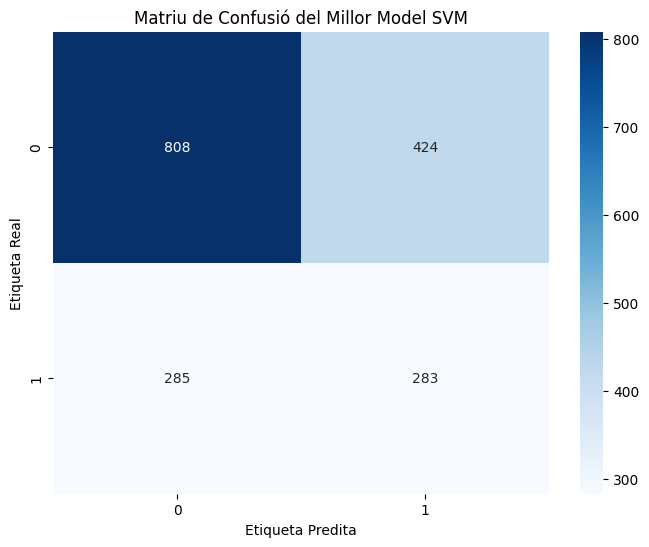

In [36]:
cm = confusion_matrix(y_test_svm, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_svm.classes_, 
            yticklabels=best_svm.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model SVM')
plt.show()

Per tal de generar una submission, haurem de preprocessar de la mateixa manera el dataset trs_eval.csv abans de fer les prediccions.

In [32]:
# ==============================================================================
# PREPROCESSING DEL DATASET D'AVALUACIÓ (trs_eval.csv)
# ==============================================================================

# 1. Carregar dades d'avaluació
df_eval = pd.read_csv('trs_eval.csv')

# Guardem els IDs per a l'arxiu de submissió final
eval_ids = df_eval['patient_id']

# Preparem X_eval (eliminem ID si hi és, igual que a train)
X_eval = df_eval.drop('patient_id', axis=1) if 'patient_id' in df_eval.columns else df_eval.copy()

print(f"Dimensions inicials eval: {X_eval.shape}")

# ------------------------------------------------------------------------------
# PAS 1: ONE-HOT ENCODING (Usem el 'ohe' ja entrenat)
# ------------------------------------------------------------------------------
# Separem numèriques i categòriques (els noms de columnes han de coincidir amb train)
cat_cols_eval = X_eval.select_dtypes(include=['object']).columns.tolist()
num_cols_eval = X_eval.select_dtypes(exclude=['object']).columns.tolist()

# Transformar (NO FIT)
X_eval_cat_encoded = ohe.transform(X_eval[cat_cols_eval])

# Convertir a DataFrame
X_eval_cat_df = pd.DataFrame(X_eval_cat_encoded, columns=new_cat_names, index=X_eval.index)

# Reconstruir DataFrame (numèriques + categòriques)
X_eval_step2 = pd.concat([X_eval[num_cols_eval], X_eval_cat_df], axis=1)

print(f"Dimensions després One-Hot: {X_eval_step2.shape}")

# ------------------------------------------------------------------------------
# PAS 2: IMPUTACIÓ KNN (Usem el 'scaler_temp' i 'knn' ja entrenats)
# ------------------------------------------------------------------------------
# 1. Escalar temporalment (usant la mitjana/std del train)
X_eval_scaled_temp = scaler_temp.transform(X_eval_step2)

# 2. Imputar (buscant veïns en el train, que estan guardats dins l'objecte knn)
X_eval_imputed_vals = knn.transform(X_eval_scaled_temp)

# 3. Des-escalar (tornar a unitats originals)
X_eval_step3 = pd.DataFrame(scaler_temp.inverse_transform(X_eval_imputed_vals), 
                            columns=X_eval_step2.columns, index=X_eval.index)

print(f"NaNs restants: {X_eval_step3.isnull().sum().sum()}")

# ------------------------------------------------------------------------------
# PAS 3: TRANSFORMACIÓ ASIMETRIA (Usem el 'pt' ja entrenat)
# ------------------------------------------------------------------------------
cols_skewed = ['Duration_untreated_psychosis', 'Age']
X_eval_step3[cols_skewed] = pt.transform(X_eval_step3[cols_skewed])

print("Transformació Box-Cox aplicada.")

# ------------------------------------------------------------------------------
# PAS 4: ESCALAT FINAL (Usem el 'scaler_final' ja entrenat)
# ------------------------------------------------------------------------------
X_eval_final = scaler_final.transform(X_eval_step3)

print("Escalat final aplicat.")

# ==============================================================================
# PREDICCIÓ I GENERACIÓ DE SUBMISSIÓ
# ==============================================================================

# Fer prediccions amb el millor model trobat
# (Assegura't que 'best_svm' o 'svm_model' és el teu model final entrenat)
final_predictions = best_svm.predict(X_eval_final) # o svm_model.predict()

# Crear DataFrame de submissió
submission = pd.DataFrame({
    'patient_id': eval_ids,
    'TRS': final_predictions
})

# Guardar a CSV
submission.to_csv('submission.csv', index=False)

print("\n" + "="*50)
print("✓ Arxiu 'submission.csv' creat correctament!")
print("Dimensions submissió:", submission.shape)
print("Distribució prediccions:")
print(submission['TRS'].value_counts())
print("="*50)


Dimensions inicials eval: (1000, 26)
Dimensions després One-Hot: (1000, 30)
NaNs restants: 0
Transformació Box-Cox aplicada.
Escalat final aplicat.

✓ Arxiu 'submission.csv' creat correctament!
Dimensions submissió: (1000, 2)
Distribució prediccions:
TRS
0    665
1    335
Name: count, dtype: int64


Provem a ajustar el model SVM a partir dels components principals (PCA) per veure si millora el rendiment. Aprofiem els 4 primers passos ja fets en el preprocessament per a SVM i afegim:

In [16]:
# Triem n_components=0.95 (mantenir el 95% de la variància explicada)
# O pots posar un enter, ex: n_components=10
pca = PCA(n_components=0.95, random_state=42)

# Fit només en Train
X_train_pca = pca.fit_transform(X_train_svm_final)
# Transform en Test
X_test_pca = pca.transform(X_test_svm_final)

print(f"Dimensions originals: {X_train_svm_final.shape}")
print(f"Dimensions després PCA: {X_train_pca.shape}")
print(f"Nombre de components retinguts: {pca.n_components_}")

Dimensions originals: (7200, 30)
Dimensions després PCA: (7200, 25)
Nombre de components retinguts: 25


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# 1. Definir la Pipeline (Seqüència d'operacions)
# Pas 1: PCA
# Pas 2: SVM
pipe_pca_svm = Pipeline([
    ('pca', PCA(random_state=42)),
    ('svm', SVC(class_weight='balanced', random_state=42))
])

#calculem proporció de la classe objectiu per definir pesos
class_counts = y_train_svm.value_counts()
print("Comptatge de classes en el conjunt d'entrenament:")
print(class_counts)

class_weights = {
    0: 1,
    1: class_counts[0] / class_counts[1]  # Pes inversament proporcional a la freqüència
}

# 2. Definir la graella de paràmetres (Param Grid)
# IMPORTANT: Posem el nom del pas seguit de doble guió baix __
param_grid = {
    # PARÀMETRES DEL PCA
    # Provem mantenir diferents % de variància o número fix de components
    'pca__n_components': [ 0.99], 
    
    # PARÀMETRES DEL SVM
    'svm__C': [0.01, 0.1, 1],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf'],
    'svm__class_weight': ['balanced', {0: 1, 1: 2}, class_weights, {0:1, 1:3}]  # Prova amb pesos diferents per a les classes
}

# 3. Configurar el Grid Search
grid_pca = GridSearchCV(
    estimator=pipe_pca_svm,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro', # Optimitzem F1-score (millor per desbalanceig)
    verbose=2,
    n_jobs=-1
)

# 4. Executar (Fit)
# Passem les dades ESCALADES (PCA requereix escalat previ)
print("Iniciant Grid Search (PCA + SVM)...")
grid_pca.fit(X_train_svm_final, y_train_svm)

# 5. Resultats
print("\n" + "="*50)
print(f"MILLOR COMBINACIÓ: {grid_pca.best_params_}")
print(f"MILLOR SCORE (CV): {grid_pca.best_score_:.4f}")
print("="*50)

# 6. Avaluar al Test Set
# La pipeline s'encarrega automàticament de fer pca.transform() i svm.predict()
best_model = grid_pca.best_estimator_
y_pred_pca = best_model.predict(X_test_svm_final)

print("\n--- RESULTATS FINALS (TEST SET) ---")
print(classification_report(y_test_svm, y_pred_pca))


Comptatge de classes en el conjunt d'entrenament:
TRS
0    4930
1    2270
Name: count, dtype: int64
Iniciant Grid Search (PCA + SVM)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

MILLOR COMBINACIÓ: {'pca__n_components': 0.99, 'svm__C': 0.1, 'svm__class_weight': {0: 1, 1: 2}, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
MILLOR SCORE (CV): 0.5890

--- RESULTATS FINALS (TEST SET) ---
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1232
           1       0.40      0.50      0.45       568

    accuracy                           0.61      1800
   macro avg       0.57      0.58      0.57      1800
weighted avg       0.63      0.61      0.62      1800



F1-Score del millor model PCA+SVM en Test Set: 0.5715


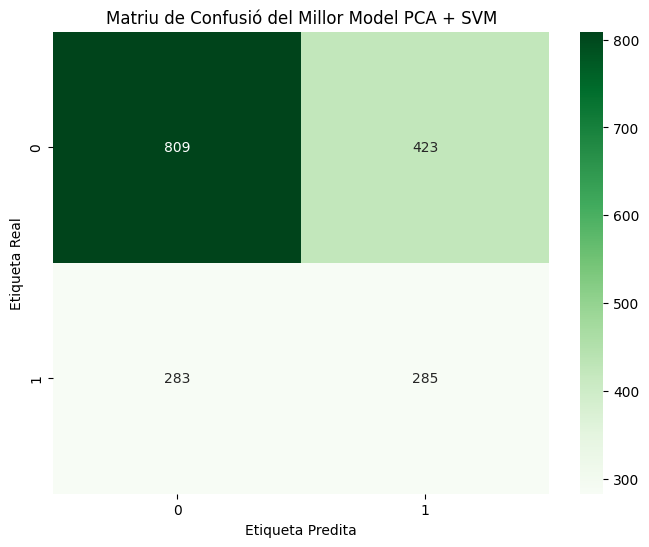

In [40]:
f1_pca = f1_score(y_test_svm, y_pred_pca, average='macro')
print(f"F1-Score del millor model PCA+SVM en Test Set: {f1_pca:.4f}")

# Matriu de confusió
cm_pca = confusion_matrix(y_test_svm, y_pred_pca)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens', 
            xticklabels=best_model.named_steps['svm'].classes_, 
            yticklabels=best_model.named_steps['svm'].classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model PCA + SVM')
plt.show()


In [ ]:

final_predictions_pca = best_model.predict(X_eval_final)

# (La resta igual)
submission_pca = pd.DataFrame({
    'patient_id': eval_ids,
    'TRS': final_predictions_pca
})
submission_pca.to_csv('submission_pca_svm.csv', index=False)


## 2.2 Per a XGBoost

1. Particionar

In [44]:
df = pd.read_csv('trs_train.csv')

if 'TRS' in df.columns:
    X = df.drop('TRS', axis=1)
    y = df['TRS']
else:
    raise ValueError("No s'ha trobat la columna TRS")

if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)

print(f"Dimensions inicials: {X.shape}")

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train XGB shape: {X_train_xgb.shape}")

Dimensions inicials: (9000, 26)
Train XGB shape: (7200, 26)


2. Codificació de variables categòriques amb One-Hot Encoding

In [45]:
cat_cols = X_train_xgb.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_xgb.select_dtypes(exclude=['object']).columns.tolist()

# Inicialitzem Encoder (IMPORTANT: sparse_output=False per tenir matriu densa)
ohe_xgb = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# Fit en Train
ohe_xgb.fit(X_train_xgb[cat_cols])

# Transform
X_train_cat = ohe_xgb.transform(X_train_xgb[cat_cols])
X_test_cat = ohe_xgb.transform(X_test_xgb[cat_cols])

# Convertir a DataFrame
new_names = ohe_xgb.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=new_names, index=X_train_xgb.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=new_names, index=X_test_xgb.index)

# Reconstruir (Numèriques + Categòriques)
X_train_xgb = pd.concat([X_train_xgb[num_cols], X_train_cat_df], axis=1)
X_test_xgb = pd.concat([X_test_xgb[num_cols], X_test_cat_df], axis=1)

print(f"Dimensions després encoding: {X_train_xgb.shape}")


Dimensions després encoding: (7200, 30)


3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [46]:
from sklearn.preprocessing import StandardScaler
scaler_temp_xgb = StandardScaler()

X_train_scaled_temp = scaler_temp_xgb.fit_transform(X_train_xgb)
X_test_scaled_temp = scaler_temp_xgb.transform(X_test_xgb)

knn_xgb = KNNImputer(n_neighbors=5)

X_train_imputed = knn_xgb.fit_transform(X_train_scaled_temp)
X_test_imputed = knn_xgb.transform(X_test_scaled_temp)

# TORNAR A L'ESCALA ORIGINAL (MOLT IMPORTANT PER A XGBOOST)
# XGBoost prefereix els valors reals (anys, glucosa mg/dL...) per fer talls llegibles
X_train_xgb = pd.DataFrame(scaler_temp_xgb.inverse_transform(X_train_imputed), 
                           columns=X_train_xgb.columns, index=X_train_xgb.index)
X_test_xgb = pd.DataFrame(scaler_temp_xgb.inverse_transform(X_test_imputed), 
                          columns=X_test_xgb.columns, index=X_test_xgb.index)

print(f"Valors perduts restants: {X_train_xgb.isnull().sum().sum()}")

Valors perduts restants: 0


4. Entrenament del model XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# 1. Calcular el ratio per al desbalanceig (com abans)
ratio_xgb = float(np.sum(y_train_xgb == 0)) / np.sum(y_train_xgb == 1)
print(f"Ratio calculat per scale_pos_weight: {ratio_xgb:.2f}")

# 2. Definir el model base
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 3. Definir la graella de paràmetres
param_grid_xgb = {
    # Profunditat de l'arbre: Valors típics entre 3 i 10
    'max_depth': [5],
    
    # Velocitat d'aprenentatge: Menys és més precís, però requereix més arbres
    'learning_rate': [0.0001, 0.001,0.01],
    
    # Nombre d'arbres:
    'n_estimators':  [1000],
    
    # Gestió desbalanceig:
    # 1.0 = per defecte
    # ratio_xgb = equilibrat matemàticament
    # ratio_xgb * 1.5 = donar encara més prioritat a trobar els casos positius
    'scale_pos_weight': [1, ratio_xgb, ratio_xgb * 1.5],
    
    # Regularització (per evitar overfitting)
    # subsample: % de dades usades per arbre (0.8 sol anar molt bé)
    'subsample': [0.8],
    'colsample_bytree': [0.8],
 
}

# 4. Configurar el Grid Search
grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=5,                 # 5-Fold Cross Validation
    scoring='f1_macro',   # O 'roc_auc' si prefereixes
    verbose=1,
    n_jobs=-1             # Paral·lelització total
)

# 5. Entrenar
print("Iniciant Grid Search per XGBoost...")
grid_xgb.fit(X_train_xgb, y_train_xgb)

# 6. Resultats
print("\n" + "="*50)
print(f"MILLORS PARÀMETRES: {grid_xgb.best_params_}")
print(f"MILLOR SCORE (CV): {grid_xgb.best_score_:.4f}")
print("="*50)

# 7. Avaluar al Test Set
best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test_xgb)

print("\n--- RESULTATS MILLOR XGBOOST (TEST SET) ---")
print(classification_report(y_test_xgb, y_pred_best_xgb))


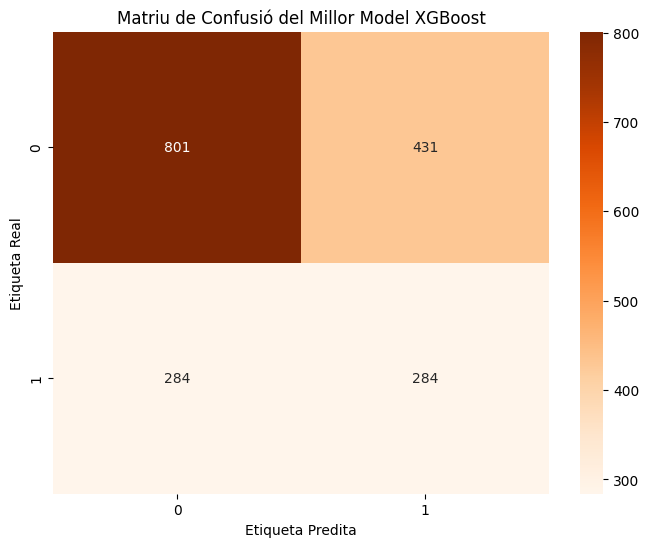

F1-Score del millor model XGBoost en Test Set: 0.5671
Dimensions inicials eval XGB: (1000, 26)
Dimensions després One-Hot XGB: (1000, 30)
NaNs restants XGB: 0


In [54]:
# veiem la matriu de confusió
cm_xgb = confusion_matrix(y_test_xgb, y_pred_best_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=best_xgb.classes_, 
            yticklabels=best_xgb.classes_)  
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Millor Model XGBoost')
plt.show()
f1_xgb = f1_score(y_test_xgb, y_pred_best_xgb, average='macro')
print(f"F1-Score del millor model XGBoost en Test Set: {f1_xgb:.4f}")

# PREDICCIÓ SOBRE EL DATASET D'AVALUACIÓ (trs_eval.csv)
df_eval_xgb = pd.read_csv('trs_eval.csv')
eval_ids_xgb = df_eval_xgb['patient_id']
X_eval_xgb = df_eval_xgb.drop('patient_id', axis=1) if 'patient_id' in df_eval_xgb.columns else df_eval_xgb.copy()
print(f"Dimensions inicials eval XGB: {X_eval_xgb.shape}")
# One-Hot Encoding
cat_cols_eval_xgb = X_eval_xgb.select_dtypes(include=['object']).columns.tolist()
num_cols_eval_xgb = X_eval_xgb.select_dtypes(exclude=['object']).columns.tolist()
X_eval_cat_xgb = ohe_xgb.transform(X_eval_xgb[cat_cols_eval_xgb])
X_eval_cat_df_xgb = pd.DataFrame(X_eval_cat_xgb, columns=new_names, index=X_eval_xgb.index)
X_eval_step2_xgb = pd.concat([X_eval_xgb[num_cols_eval_xgb], X_eval_cat_df_xgb], axis=1)
print(f"Dimensions després One-Hot XGB: {X_eval_step2_xgb.shape}")
# Imputació KNN
X_eval_scaled_temp_xgb = scaler_temp_xgb.transform(X_eval_step2_xgb)
X_eval_imputed_xgb = knn_xgb.transform(X_eval_scaled_temp_xgb)
X_eval_step3_xgb = pd.DataFrame(scaler_temp_xgb.inverse_transform(X_eval_imputed_xgb), 
                            columns=X_eval_step2_xgb.columns, index=X_eval_step2_xgb.index)
print(f"NaNs restants XGB: {X_eval_step3_xgb.isnull().sum().sum()}")
# Prediccions
final_predictions_xgb = best_xgb.predict(X_eval_step3_xgb)
submission_xgb = pd.DataFrame({
    'patient_id': eval_ids_xgb,
    'TRS': final_predictions_xgb
})
submission_xgb.to_csv('submission_xgb.csv', index=False)



## 2.3 Per a Regressió Logística personalitzada

1. Particionar


In [55]:
df = pd.read_csv('trs_train.csv')

if 'TRS' in df.columns:
    X = df.drop('TRS', axis=1)
    y = df['TRS']
else:
    raise ValueError("No s'ha trobat la columna TRS")

if 'patient_id' in X.columns:
    X = X.drop('patient_id', axis=1)

print(f"Dimensions inicials: {X.shape}")

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train LogReg shape: {X_train_lr.shape}")

Dimensions inicials: (9000, 26)
Train LogReg shape: (7200, 26)


2. Codificació de variables categòriques amb One-Hot Encoding

In [56]:
# PAS 2 (REAL): One-Hot Encoding
cat_cols = X_train_lr.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_lr.select_dtypes(exclude=['object']).columns.tolist()

ohe_lr = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
ohe_lr.fit(X_train_lr[cat_cols])

# Transformem
X_train_cat = ohe_lr.transform(X_train_lr[cat_cols])
X_test_cat = ohe_lr.transform(X_test_lr[cat_cols])

# Convertir a DataFrame
new_names = ohe_lr.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=new_names, index=X_train_lr.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=new_names, index=X_test_lr.index)

# Reconstruir
X_train_lr = pd.concat([X_train_lr[num_cols], X_train_cat_df], axis=1)
X_test_lr = pd.concat([X_test_lr[num_cols], X_test_cat_df], axis=1)

print(f"Dimensions després Encoding: {X_train_lr.shape}")

Dimensions després Encoding: (7200, 30)


3. Imputació de valors faltants amb KNNImputer amb ``k=5``

In [57]:
scaler_temp_lr = StandardScaler()
X_train_scaled_temp = scaler_temp_lr.fit_transform(X_train_lr)
X_test_scaled_temp = scaler_temp_lr.transform(X_test_lr)

knn_lr = KNNImputer(n_neighbors=5)
X_train_imputed_vals = knn_lr.fit_transform(X_train_scaled_temp)
X_test_imputed_vals = knn_lr.transform(X_test_scaled_temp)

# Tornem a l'escala original per poder fer Box-Cox
X_train_lr = pd.DataFrame(scaler_temp_lr.inverse_transform(X_train_imputed_vals), 
                          columns=X_train_lr.columns, index=X_train_lr.index)
X_test_lr = pd.DataFrame(scaler_temp_lr.inverse_transform(X_test_imputed_vals), 
                         columns=X_test_lr.columns, index=X_test_lr.index)

print(f"Valors perduts restants: {X_train_lr.isnull().sum().sum()}")

Valors perduts restants: 0


4. Transformació de variables numèriques per reduir skewness amb PowerTransformer (Box-Cox o Yeo-Johnson segons correspongui)

In [58]:
pt_lr = PowerTransformer(method='yeo-johnson', standardize=False)
cols_skewed = ['Duration_untreated_psychosis', 'Age']

pt_lr.fit(X_train_lr[cols_skewed])

X_train_lr[cols_skewed] = pt_lr.transform(X_train_lr[cols_skewed])
X_test_lr[cols_skewed] = pt_lr.transform(X_test_lr[cols_skewed])

print("Transformació Yeo-Johnson aplicada.")

Transformació Yeo-Johnson aplicada.


5. Escalat de les variables numèriques amb StandardScaler

In [59]:
scaler_final_lr = StandardScaler()

X_train_lr_final = scaler_final_lr.fit_transform(X_train_lr)
X_test_lr_final = scaler_final_lr.transform(X_test_lr)

print("Escalat final completat.")

Escalat final completat.


1. Model de Regressió Logística personalitzada 

In [60]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, n_iterations=1000, batch_size=32, random_state=42):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.losses = []

    def _sigmoid(self, z):
        # Funció d'activació Sigmoid: 1 / (1 + e^-z)
        # np.clip per evitar overflow en valors extrems
        z = np.clip(z, -250, 250) 
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Assegurar que treballem amb numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        n_samples, n_features = X.shape
        
        # 1. Inicialitzar pesos i bias (a zero o random petit)
        np.random.seed(self.random_state)
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.losses = []

        # 2. Bucle d'entrenament (Epochs)
        for i in range(self.n_iterations):
            
            # A. Barrejar dades (Shuffle) - CRUCIAL per a Stochastic/Mini-batch
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # B. Bucle de Mini-Batch
            # Iterem per blocs de mida 'batch_size'
            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_samples)
                
                # Extreure el batch
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                
                current_batch_size = X_batch.shape[0]

                # --- Forward Pass ---
                # z = w*x + b
                linear_model = np.dot(X_batch, self.weights) + self.bias
                # y_pred = sigmoid(z)
                y_predicted = self._sigmoid(linear_model)

                # --- Backward Pass (Càlcul de Gradients) ---
                # Derivada respecte als pesos: (1/m) * X.T * (y_pred - y_real)
                dw = (1 / current_batch_size) * np.dot(X_batch.T, (y_predicted - y_batch))
                # Derivada respecte al bias: (1/m) * sum(y_pred - y_real)
                db = (1 / current_batch_size) * np.sum(y_predicted - y_batch)

                # --- Update Weights (Descens de Gradient) ---
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            
            # (Opcional) Calcular loss al final de l'epoch per monitoritzar
            # linear_model_full = np.dot(X, self.weights) + self.bias
            # y_pred_full = self._sigmoid(linear_model_full)
            # loss = -np.mean(y * np.log(y_pred_full + 1e-9) + (1-y) * np.log(1-y_pred_full + 1e-9))
            # self.losses.append(loss)
            
        return self

    def predict_proba(self, X):
        X = np.array(X)
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X):
        y_pred_proba = self.predict_proba(X)
        # Retornar 1 si prob > 0.5, sinó 0
        return [1 if i > 0.5 else 0 for i in y_pred_proba]

Entrenant Custom Logistic Regression (Mini-Batch)...

--- RESULTATS CUSTOM LOGISTIC REGRESSION ---
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      1232
           1       0.45      0.08      0.14       568

    accuracy                           0.68      1800
   macro avg       0.57      0.52      0.47      1800
weighted avg       0.62      0.68      0.59      1800

Accuracy: 0.6789

Comparativa (Real vs Predit):
Real:   [1 0 0 1 0 1 0 0 1 0]
Predit: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
F1-Score del model Logistic Regression en Test Set: 0.4712


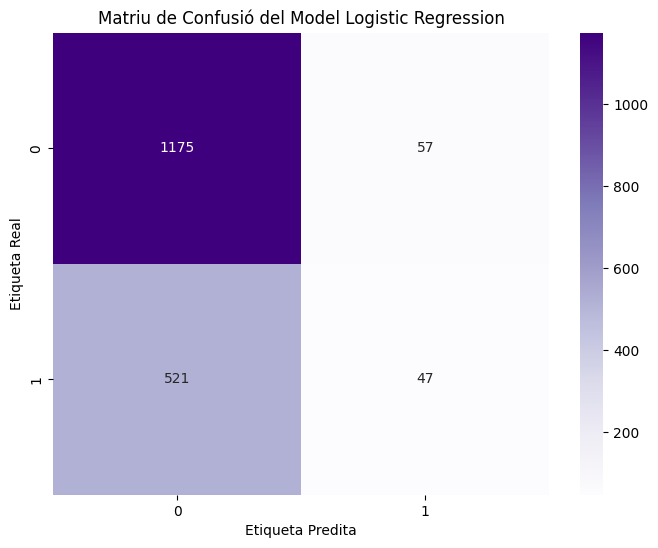

In [64]:
from sklearn.metrics import classification_report, accuracy_score

# 1. Instanciar el nostre model customitzat
# batch_size=32 o 64 és estàndard. 
# learning_rate=0.01 sol anar bé per dades escalades.
custom_lr = CustomLogisticRegression(
    learning_rate=0.01, 
    n_iterations=200,   # Nombre d'epochs (passades completes per les dades)
    batch_size=32, 
    random_state=42
)

print("Entrenant Custom Logistic Regression (Mini-Batch)...")
custom_lr.fit(X_train_lr_final, y_train_lr)

# 2. Predir
y_pred_custom = custom_lr.predict(X_test_lr_final)

# 3. Avaluar
print("\n--- RESULTATS CUSTOM LOGISTIC REGRESSION ---")
print(classification_report(y_test_lr, y_pred_custom))
print(f"Accuracy: {accuracy_score(y_test_lr, y_pred_custom):.4f}")

# (Opcional) Comparar els primers 10 valors reals vs predits
print("\nComparativa (Real vs Predit):")
print(f"Real:   {y_test_lr.values[:10]}")
print(f"Predit: {y_pred_custom[:10]}")

# F1-Score
f1_lr = f1_score(y_test_lr, y_pred_custom, average='macro')
print(f"F1-Score del model Logistic Regression en Test Set: {f1_lr:.4f}")

# Matriu de confusió
cm_lr = confusion_matrix(y_test_lr, y_pred_custom)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', 
            xticklabels=[0, 1], 
            yticklabels=[0, 1])
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predita')
plt.title('Matriu de Confusió del Model Logistic Regression')
plt.show()
